<a href="https://colab.research.google.com/github/chris051091/Tesis_Maestria/blob/main/anomalias/src/Anomalias_vizcaina_20h_7h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install windrose

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import timedelta
import matplotlib.cm as cm
from functools import reduce
from math import cos, sin, atan, pi
from windrose import WindroseAxes
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_DADOS_EVENTOS = '/dados/'
PATH_ANOMALIAS = '/anomalias/'
NOMBRE_ESTACION = 'vizcaina'
FILE_DATOS_ESTACION = 'eventos_vizcaina_2.csv'

LISTA_VAR = ['temp', 'hum', 'pres', 'hum_especifica']
LISTA_PWV = []
LISTA_VAR_10M = ['viento']
LISTA_PREC = ['prec']

PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'
FILES_TRATADOS = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR]
FILES_PWV = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PWV]
FILES_TRATADOS_10M = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR_10M]
FILES_TRATADOS_PREC = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PREC]

PATH_FINAL_FIGURAS_ANOMALIAS = PATH_DRIVE + PATH_ANOMALIAS + NOMBRE_ESTACION

Cargando datos de Temp, Hum, Pres

In [4]:
dfList = []
for f in FILES_TRATADOS:
  df = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';',
                )
  dfList.append(df)

In [5]:
df = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
df = df.sort_values(by=['FECHA']).reset_index(drop = True)
df['HORA'] = df['FECHA'].apply(lambda x: x[11:13])

Cargando datos de Vapor de Agua

In [6]:
dfList = []
PWV_columns = []
if FILES_PWV:

  for f in FILES_PWV:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';',
                  )
    dfList.append(dfp)
    PWV_columns += [col for col in dfp if col != 'FECHA']


  dfPWV = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPWV = dfPWV.sort_values(by=['FECHA']).reset_index(drop = True)

  dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PWV_columns:
    dfPWV = dfPWV.loc[~dfPWV[var].isnull()].reset_index(drop = True)

  dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPWV = pd.DataFrame(columns = ['FECHA', 'PWV'])

In [7]:
dfPWV

,FECHA,PWV


## Cargando datos de Vientos

$ \theta_p  = arctan(U_p / V_p) $ Direccíon del viento promedio

In [8]:
dfList = []
for f in FILES_TRATADOS_10M:
  dfaux = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';',
                )
  dfList.append(dfaux)

In [9]:
df10m = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)

df10m['FECHA_HORA'] = df10m['FECHA'].apply(lambda x: x[0:13])
df10m['X_VIENTO'] = df10m['VELVIENTO'] * np.sin(np.deg2rad(df10m['DIRECVIENTO'] - 180))
df10m['Y_VIENTO'] = df10m['VELVIENTO'] * np.cos(np.deg2rad(df10m['DIRECVIENTO'] - 180))

dfViento = df10m.copy()

df10m = df10m.groupby('FECHA_HORA').agg({'X_VIENTO' : 'mean', 'Y_VIENTO' : 'mean' }).reset_index()
df10m['HORA'] = df10m['FECHA_HORA'].apply(lambda x: x[11:13])
df10m['FECHA'] = pd.to_datetime(df10m['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)

## Cargando datos de precipitación

In [10]:
dfList = []
PREC_columns = []
if FILES_TRATADOS_PREC:

  for f in FILES_TRATADOS_PREC:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';',
                  )
    dfList.append(dfp)
    PREC_columns += [col for col in dfp if col != 'FECHA']


  dfPrec = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPrec = dfPrec.sort_values(by=['FECHA']).reset_index(drop = True)

  # dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  # dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PREC_columns:
    dfPrec = dfPrec.loc[~dfPrec[var].isnull()].reset_index(drop = True)

  # dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPrec = pd.DataFrame(columns = ['FECHA'])



In [11]:
dfPrec

,FECHA,PREC
0,2011-01-01 00:10:00-05:00,0.0
1,2011-01-01 00:20:00-05:00,0.0
2,2011-01-01 00:30:00-05:00,0.0
3,2011-01-01 00:40:00-05:00,0.0
4,2011-01-01 00:50:00-05:00,0.0
...,...,...
307942,2017-12-31 23:10:00-05:00,0.0
307943,2017-12-31 23:20:00-05:00,0.0
307944,2017-12-31 23:30:00-05:00,0.0
307945,2017-12-31 23:40:00-05:00,0.0


## Cruzamiento de datos de Temp, hum y pres con PWV

In [12]:
dfDatos = pd.merge(df[['FECHA', 'TEMP', 'HUM', 'PRESION','HUM_ESPECIFICA']], dfPWV[['FECHA', 'PWV']], on = 'FECHA', how = 'outer')
dfDatos['HORA'] = dfDatos['FECHA'].apply(lambda x: x[11:13])

dfmean = dfDatos.groupby('HORA').agg('mean').reset_index(level=0)

columns_mean = [col for col in dfmean.columns if col != 'HORA']
for col in columns_mean:
  dfmean = dfmean.rename(columns={col : f'{col}_mean'})

dfmean

<ipython-input-12-dc4af6471bed>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfmean = dfDatos.groupby('HORA').agg('mean').reset_index(level=0)


,HORA,TEMP_mean,HUM_mean,PRESION_mean,HUM_ESPECIFICA_mean
0,00,24.949769,97.271719,1001.032763,19.665140
1,01,24.667473,97.775870,1000.718776,19.427645
2,02,24.399024,98.207073,1000.450000,19.194948
3,03,24.154609,98.539831,1000.453592,18.990761
4,04,23.944444,98.839627,1000.738608,18.793811
5,05,23.748298,99.090145,1001.267384,18.616688
6,06,23.632011,99.273960,1001.947804,18.502058
7,07,24.837488,97.721751,1002.880737,19.611970
8,08,26.738325,88.308015,1003.747234,20.396888
9,09,29.187494,79.935634,1002.756255,20.855868


## Cargando Df de los eventos

In [13]:
dfEventos = pd.read_csv(PATH_DRIVE + PATH_DADOS_EVENTOS + FILE_DATOS_ESTACION,
                 sep = ';'
                )
dfEventos = dfEventos.sort_values(by='DATE_MIN_T').reset_index(drop = True)
dfEventos['FECHA'] = pd.to_datetime(dfEventos['DATE_MIN_T'], format='%Y-%m-%d %H:%M').dt.tz_localize('America/Bogota')
dfEventos['FECHA_MIN'] = dfEventos['FECHA'].dt.round('10min')
dfEventos['FECHA'] = dfEventos['FECHA'].dt.round('H')
dfEventos = dfEventos[['FECHA', 'FECHA_MIN', 'MIN_T', 'LON', 'LAT']]
dfEventos

,FECHA,FECHA_MIN,MIN_T,LON,LAT
0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058
1,2011-04-23 20:00:00-05:00,2011-04-23 20:20:00-05:00,196.2,-73.693,6.915
2,2011-05-02 03:00:00-05:00,2011-05-02 02:40:00-05:00,190.2,-73.836,7.058
3,2011-06-07 05:00:00-05:00,2011-06-07 05:20:00-05:00,193.6,-73.693,7.058
4,2011-06-19 04:00:00-05:00,2011-06-19 04:20:00-05:00,205.3,-73.693,7.058
...,...,...,...,...,...
56,2017-11-02 03:00:00-05:00,2017-11-02 03:20:00-05:00,209.6,-73.836,7.058
57,2017-11-02 04:00:00-05:00,2017-11-02 03:40:00-05:00,208.0,-73.836,7.058
58,2017-11-03 01:00:00-05:00,2017-11-03 01:20:00-05:00,208.6,-73.836,7.058
59,2017-11-08 21:00:00-05:00,2017-11-08 21:20:00-05:00,199.1,-73.693,6.915


# Cargando Eventos e encontrando intervalo n horas antes y después

In [14]:
funtime = lambda x, hour : [x + timedelta(hours = h) for h in (range(0, hour+1) if hour > 0 else range(hour, 0))]

# [base - datetime.timedelta(days=x) for x in range(numdays)]
dfEventAn = dfEventos.copy()
# pd.set_option('display.max_colwidth', None)

# ==================================
int_horas = 8
int_minutes = int_horas * 6 * 10
# ==================================
dfEventAn['FECHA_ANTES'] = dfEventAn['FECHA'].apply(funtime, hour = -int_horas)
dfEventAn['FECHA_DESPUES'] = dfEventAn['FECHA'].apply(funtime, hour = int_horas)
dfEventAn['FECHA_INTERVALO'] = dfEventAn['FECHA_ANTES'] + dfEventAn['FECHA_DESPUES']
dfEventAn = dfEventAn.drop(columns=['FECHA_ANTES', 'FECHA_DESPUES']).explode('FECHA_INTERVALO')
dfEventAn['FECHA_POS'] = (dfEventAn['FECHA_INTERVALO'] - dfEventAn['FECHA'])/ pd.Timedelta(hours=1)
dfEventAn = dfEventAn.rename(columns={'FECHA' : 'FECHA_EVENTO', 'FECHA_INTERVALO': 'FECHA'}).reset_index()
dfEventAn['FECHA'] = dfEventAn['FECHA'].astype(str)


dfEventAn.head(15)

,index,FECHA_EVENTO,FECHA_MIN,MIN_T,LON,LAT,FECHA,FECHA_POS
0,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:00:00-05:00,-8.0
1,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:00:00-05:00,-7.0
2,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 23:00:00-05:00,-6.0
3,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 00:00:00-05:00,-5.0
4,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:00:00-05:00,-4.0
5,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 02:00:00-05:00,-3.0
6,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 03:00:00-05:00,-2.0
7,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 04:00:00-05:00,-1.0
8,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 05:00:00-05:00,0.0
9,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 06:00:00-05:00,1.0


# Cruzamiento con las variables metereológicas. En terminos de 1h


In [15]:
dfCross = pd.merge(dfEventAn, dfDatos, on='FECHA', how = 'left')
dfCross['HORA'] = dfCross['FECHA'].apply(lambda x: x[11:13])
dfCross = pd.merge(dfCross, dfmean, on = 'HORA', how='left')

list_anomalias = []
for col in columns_mean:
  anomalia = f'{col}_anomalia'
  list_anomalias.append(anomalia)
  dfCross[anomalia] = dfCross[f'{col}'] - dfCross[f'{col}_mean']

dfAnomalia = dfCross[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()

In [16]:
dfAnomalia

FECHA_POS TEMP_anomalia           HUM_anomalia           PRESION_anomalia  \
                      mean       std         mean       std             mean   
0       -8.0      0.159856  1.346051     0.903671  5.289435        -0.709242   
1       -7.0      0.209668  1.234617     0.720358  4.354349        -0.646450   
2       -6.0      0.387594  1.416996     0.303439  5.096419        -0.571832   
3       -5.0      0.441561  1.253533    -0.585757  5.304677        -0.706312   
4       -4.0      0.220510  0.919109     0.588704  3.965982        -0.538382   
5       -3.0      0.413138  0.822739     0.375215  3.452764        -0.640219   
6       -2.0      0.650490  0.812917    -0.229225  3.127396        -0.708797   
7       -1.0      0.491718  1.002640     0.136461  2.968172        -0.526463   
8        0.0     -0.033036  1.363542     0.136021  2.444690        -0.440623   
9        1.0     -0.740054  1.139572     0.388578  2.373367        -0.182518   
10       2.0     -1.035609  1.265476     1.486024  3.491627        -0.244368   
11       3.0     -1.119325  1.638270     2.936409  5.840420        -0.304619   
12       4.0     -1.291212  1.563287     3.916125  7.354576        -0.101515   
13       5.0     -1.247871  1.536550     4.828906  7.118358         0.018910   
14       6.0     -1.112179  1.752567     4.937357  8.096408         0.568512   
15       7.0     -1.196143  1.470295     5.447522  6.294270         0.852130   
16       8.0     -1.556895  1.689332     6.913407  6.506492         0.226972   

             HUM_ESPECIFICA_anomalia            
         std                    mean       std  
0   1.171758                0.434533  1.020697  
1   1.212804                0.474630  0.962776  
2   1.231771                0.500318  0.938117  
3   1.291095                0.523418  1.006268  
4   1.364153                0.542684  0.868280  
5   1.462721                0.781216  0.750599  
6   1.604525                0.853052  0.755341  
7   1.663567                0.624748  1.048647  
8   1.690568                0.142316  1.147254  
9   1.805764               -0.537520  1.126536  
10  1.917928               -0.538649  1.049525  
11  2.173456               -0.372137  0.899888  
12  2.320566               -0.453988  0.999356  
13  1.989440               -0.372474  1.077745  
14  2.168697                0.015874  1.057679  
15  2.365410                0.014434  1.020632  
16  1.700620                0.122102  1.215382

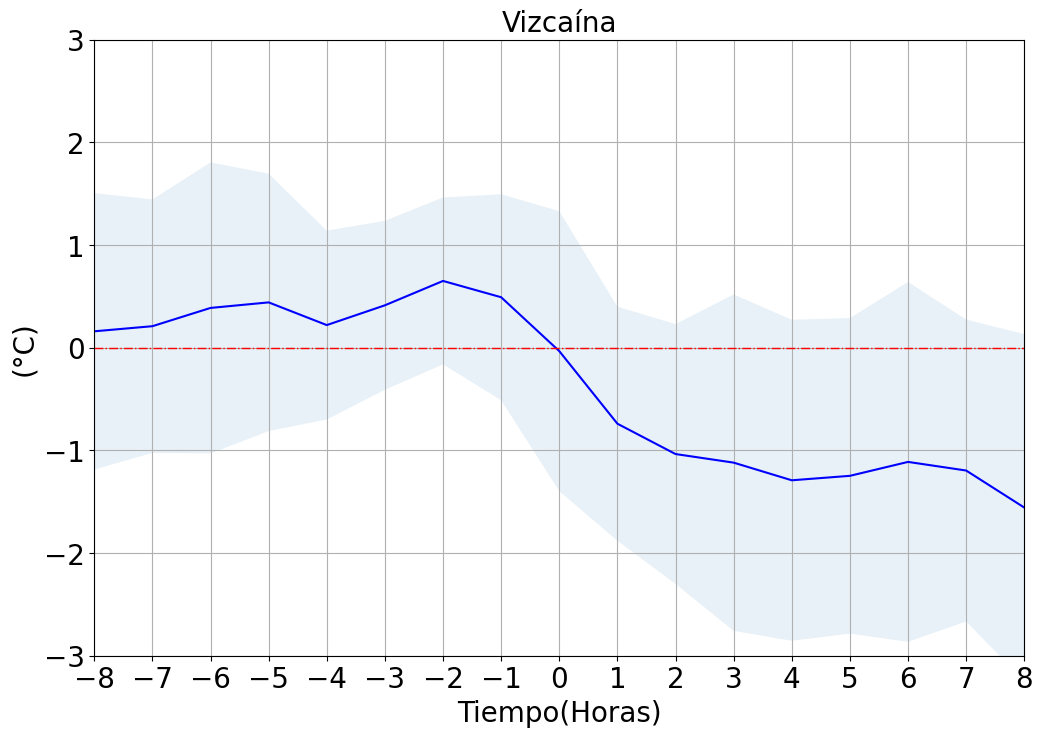

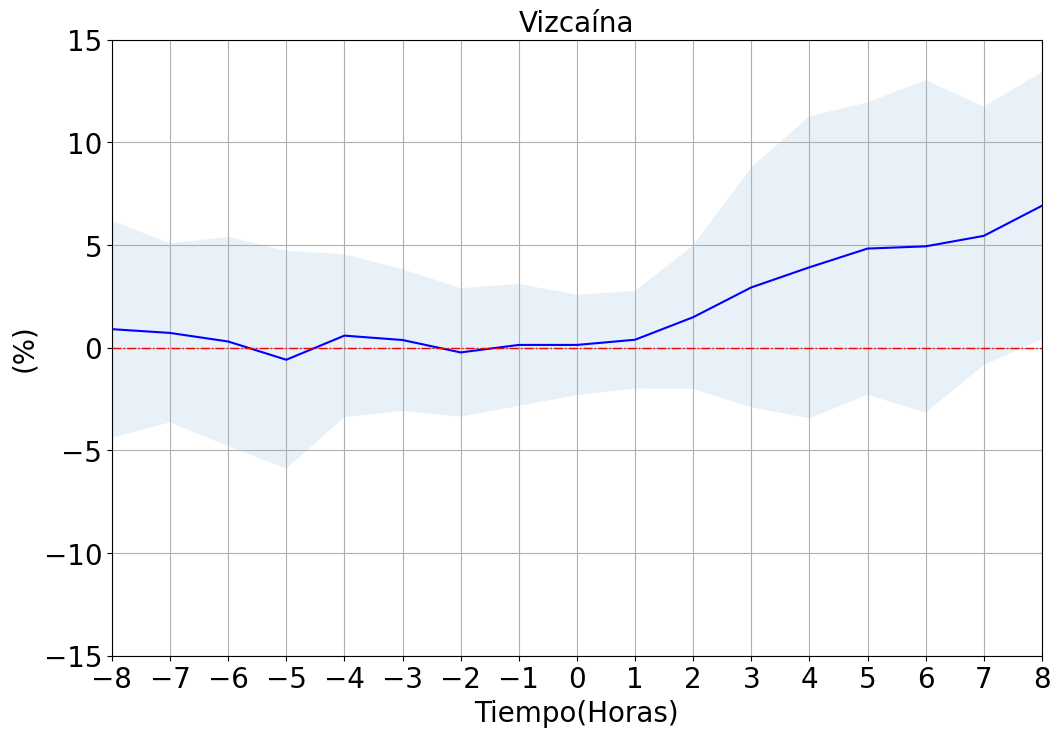

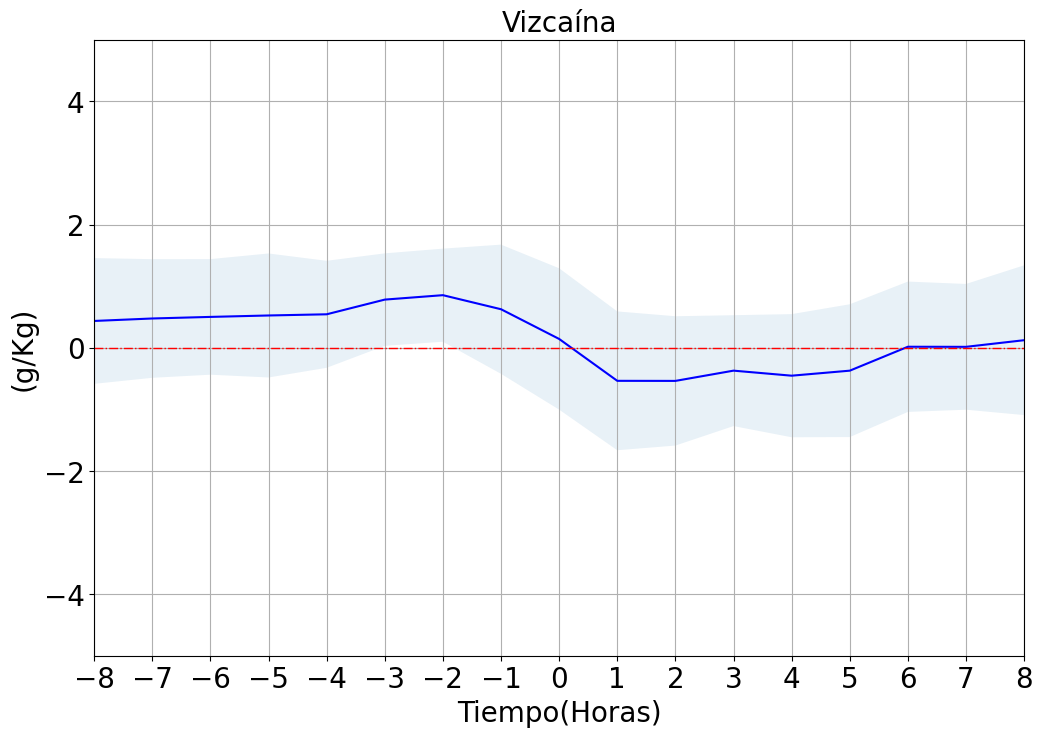

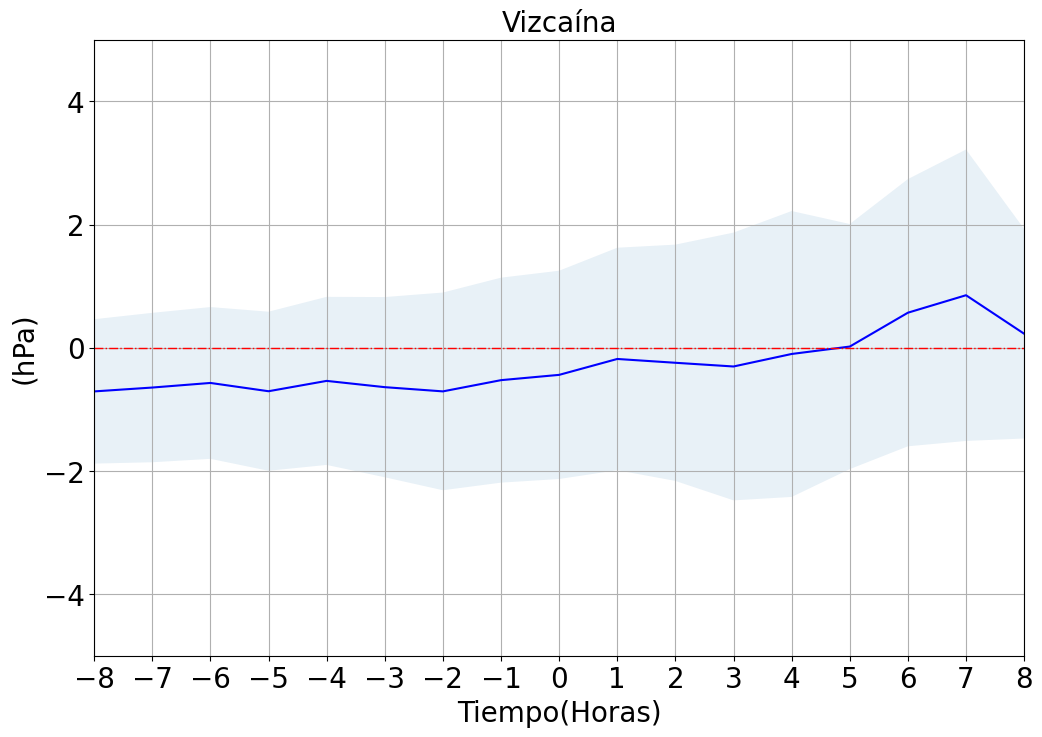

In [17]:
def plot_anomalias(df, anomalia, titulo, name_to_save, ylabel_name, int_horas, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  plt.xticks(df['FECHA_POS'], fontsize= 20)
  plt.yticks(fontsize= 20)
  plt.plot(df['FECHA_POS'], df[(anomalia, 'mean')], color = 'b')
  plt.fill_between(df['FECHA_POS'], df[(anomalia, 'mean')] + df[(anomalia, 'std')], df[(anomalia, 'mean')] - df[(anomalia, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.xlim([-int_horas, int_horas])

  if ylimit:
    plt.ylim(*ylimit)
  else:
    plt.ylim(-20,20)

  plt.xlabel("Tiempo(Horas)", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(°C)', 'ylimit': [-3, 3]},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(%)', 'ylimit': [-15, 15]},
              'HUM_ESPECIFICA_anomalia' : {'title' : 'Anomalias de Humedad Específica', 'name2save' : f'anomalias_humedad_especifica_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(g/Kg)', 'ylimit': [-5, 5]},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(hPa)', 'ylimit': [-5, 5]},
              # 'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomalia, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas, dict_names[key]['ylimit'])

# dfAnomalia

# Análisis con los 21 Eventos que tienen todas las variábles metereológicas completas

In [18]:
dfEventos0 = dfCross.loc[dfCross['FECHA_POS'] == 0.]
dfEventos0 = dfEventos0[['FECHA_EVENTO', 'MIN_T', 'index'] + columns_mean]
dfEventos0['NUMERO_VARS'] = dfEventos0[columns_mean].notnull().sum(axis=1)
dfEventos0

,FECHA_EVENTO,MIN_T,index,TEMP,HUM,PRESION,HUM_ESPECIFICA,NUMERO_VARS
8,2011-02-13 05:00:00-05:00,204.5,0,24.2,96.0,NaN,NaN,2
25,2011-04-23 20:00:00-05:00,196.2,1,NaN,NaN,NaN,NaN,0
42,2011-05-02 03:00:00-05:00,190.2,2,NaN,NaN,NaN,NaN,0
59,2011-06-07 05:00:00-05:00,193.6,3,24.9,100.0,NaN,NaN,2
76,2011-06-19 04:00:00-05:00,205.3,4,25.0,99.0,NaN,NaN,2
...,...,...,...,...,...,...,...,...
960,2017-11-02 03:00:00-05:00,209.6,56,24.8,100.0,996.7,19.954786,4
977,2017-11-02 04:00:00-05:00,208.0,57,24.6,100.0,997.6,19.697299,4
994,2017-11-03 01:00:00-05:00,208.6,58,25.1,97.0,998.6,19.678140,4
1011,2017-11-08 21:00:00-05:00,199.1,59,24.9,96.0,997.0,19.275490,4


In [19]:
dfEventos0.count()

FECHA_EVENTO      61
MIN_T             61
index             61
TEMP              45
HUM               45
PRESION           25
HUM_ESPECIFICA    25
NUMERO_VARS       61
dtype: int64

In [20]:
dfEventos0['NUMERO_VARS'].value_counts()

4    25
2    20
0    16
Name: NUMERO_VARS, dtype: int64

In [21]:
dfVarsCompletas = dfEventos0.loc[dfEventos0['NUMERO_VARS'] == 3]
indexVarsCompletas = dfVarsCompletas['index']
dfVarsComp = pd.merge(dfCross, indexVarsCompletas, on = 'index', how = 'inner')

dfAnomaliaVarsComp = dfVarsComp[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()
dfAnomaliaVarsComp

Empty DataFrame
Columns: [(FECHA_POS, ), (TEMP_anomalia, mean), (TEMP_anomalia, std), (HUM_anomalia, mean), (HUM_anomalia, std), (PRESION_anomalia, mean), (PRESION_anomalia, std), (HUM_ESPECIFICA_anomalia, mean), (HUM_ESPECIFICA_anomalia, std)]
Index: []

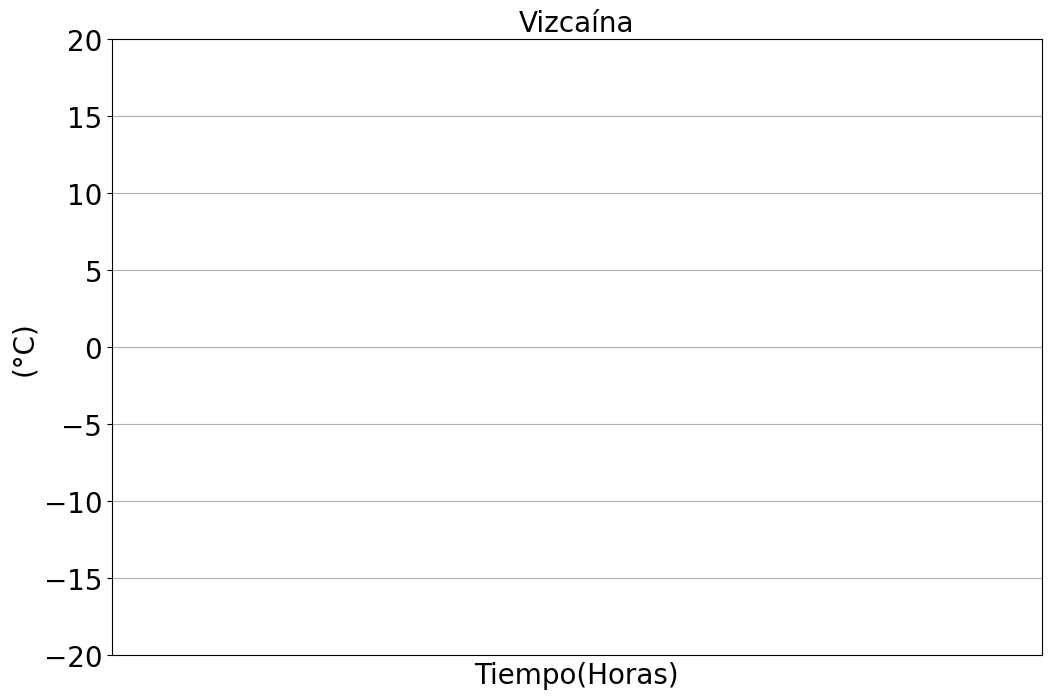

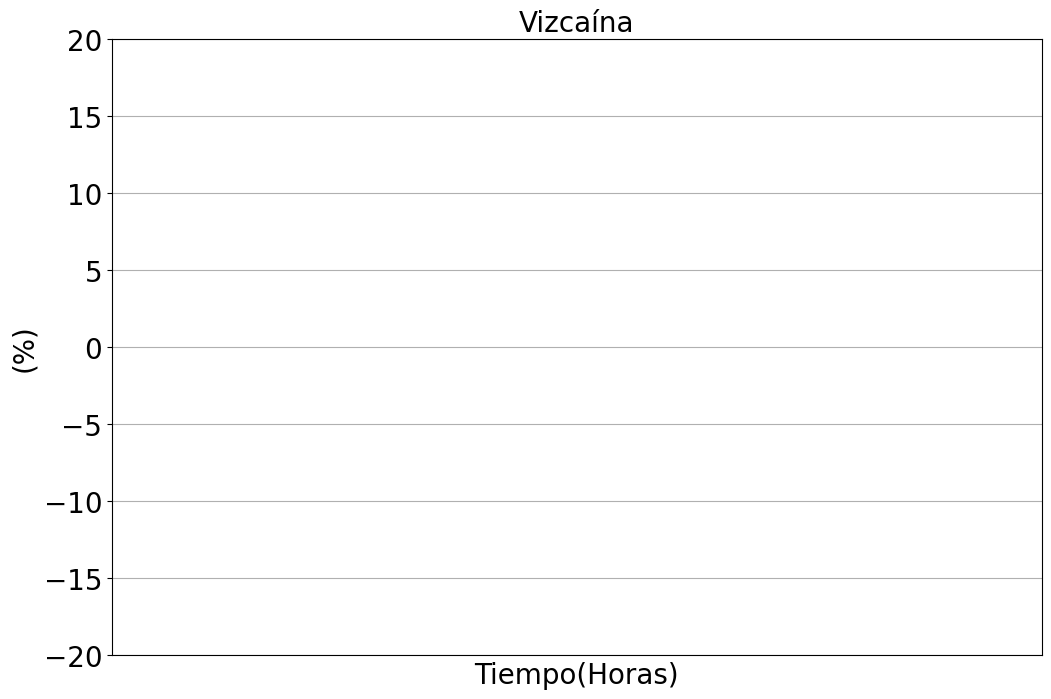

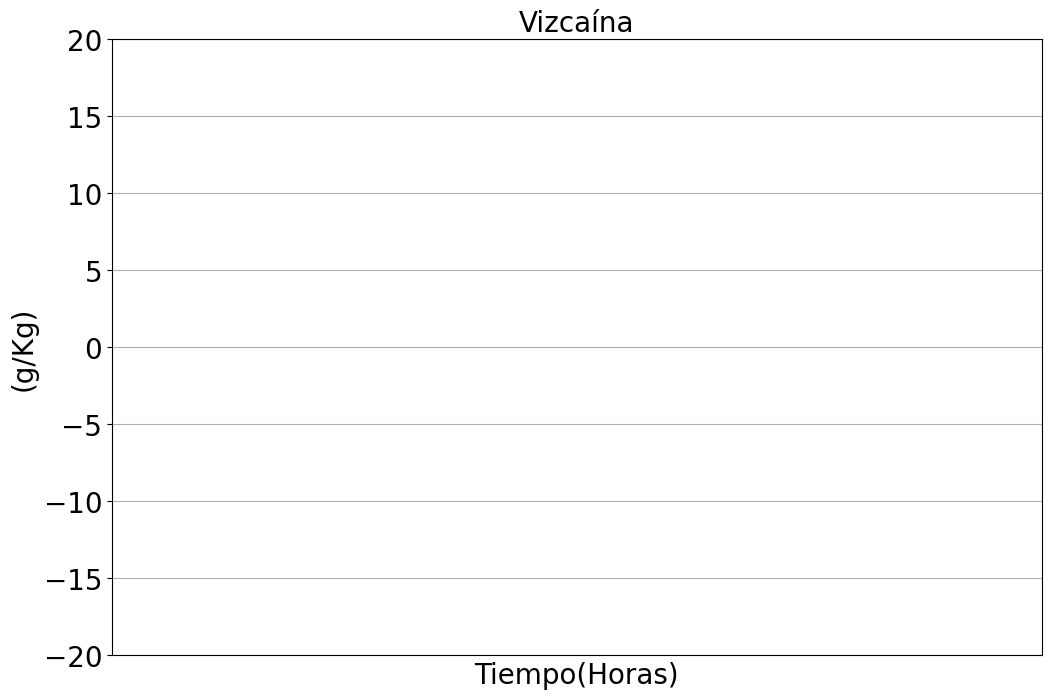

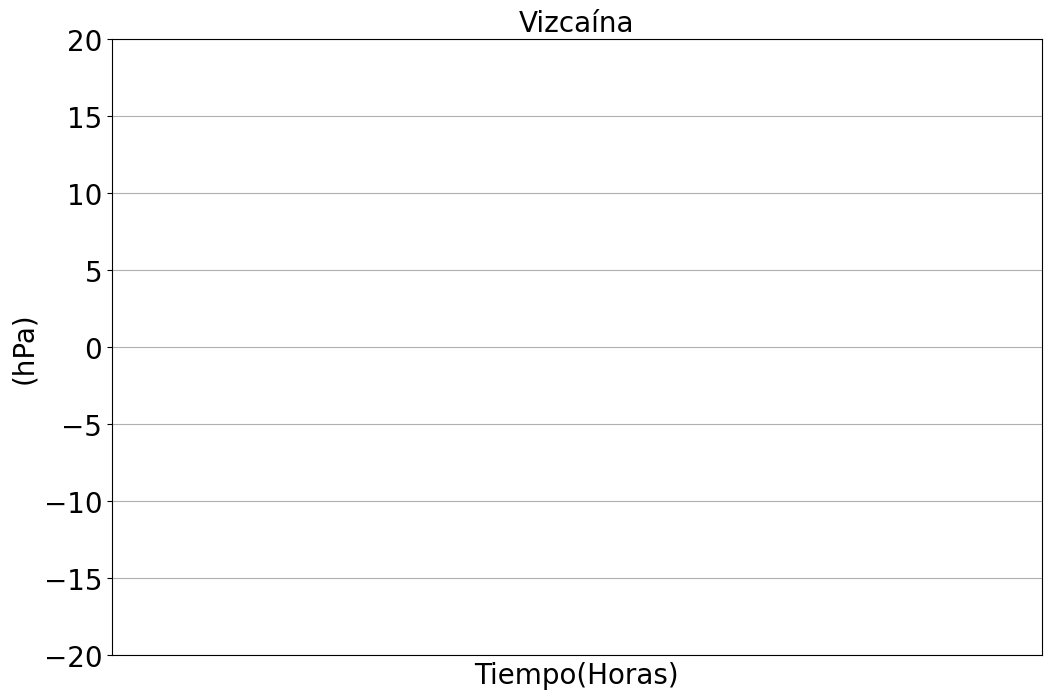

In [22]:
dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_vars_comp_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_vars_comp_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(%)'},
              'HUM_ESPECIFICA_anomalia' : {'title' : 'Anomalias de Humedad Específica', 'name2save' : f'anomalias_humedad_especifica_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(g/Kg)', 'ylimit': [-5, 5]},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_vars_comp_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(hPa)'},
              # 'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomaliaVarsComp, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

GRAFICAS CAJA BIGOTE

In [23]:
import matplotlib.cbook as cbook
import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib.cbook import _reshape_2D

# Function adapted from matplotlib.cbook
def my_boxplot_stats(X, whis=1.5, bootstrap=None, labels=None,
                  autorange=False, percents=[25, 75]):

    def _bootstrap_median(data, N=5000):
        # determine 95% confidence intervals of the median
        M = len(data)
        percentiles = [2.5, 97.5]

        bs_index = np.random.randint(M, size=(N, M))
        bsData = data[bs_index]
        estimate = np.median(bsData, axis=1, overwrite_input=True)

        CI = np.percentile(estimate, percentiles)
        return CI

    def _compute_conf_interval(data, med, iqr, bootstrap):
        if bootstrap is not None:
            # Do a bootstrap estimate of notch locations.
            # get conf. intervals around median
            CI = _bootstrap_median(data, N=bootstrap)
            notch_min = CI[0]
            notch_max = CI[1]
        else:

            N = len(data)
            notch_min = med - 1.57 * iqr / np.sqrt(N)
            notch_max = med + 1.57 * iqr / np.sqrt(N)

        return notch_min, notch_max

    # output is a list of dicts
    bxpstats = []

    # convert X to a list of lists
    X = _reshape_2D(X, "X")

    ncols = len(X)
    if labels is None:
        labels = itertools.repeat(None)
    elif len(labels) != ncols:
        raise ValueError("Dimensions of labels and X must be compatible")

    input_whis = whis
    for ii, (x, label) in enumerate(zip(X, labels)):

        # empty dict
        stats = {}
        if label is not None:
            stats['label'] = label

        # restore whis to the input values in case it got changed in the loop
        whis = input_whis

        # note tricksyness, append up here and then mutate below
        bxpstats.append(stats)

        # if empty, bail
        if len(x) == 0:
            stats['fliers'] = np.array([])
            stats['mean'] = np.nan
            stats['med'] = np.nan
            stats['q1'] = np.nan
            stats['q3'] = np.nan
            stats['cilo'] = np.nan
            stats['cihi'] = np.nan
            stats['whislo'] = np.nan
            stats['whishi'] = np.nan
            stats['med'] = np.nan
            continue

        # up-convert to an array, just to be safe
        x = np.asarray(x)

        # arithmetic mean
        stats['mean'] = np.mean(x)

        # median
        med = np.percentile(x, 50)
        ## Altered line
        q1, q3 = np.percentile(x, (percents[0], percents[1]))

        # interquartile range
        stats['iqr'] = q3 - q1
        if stats['iqr'] == 0 and autorange:
            whis = 'range'

        # conf. interval around median
        stats['cilo'], stats['cihi'] = _compute_conf_interval(
            x, med, stats['iqr'], bootstrap
        )

        # lowest/highest non-outliers
        if np.isscalar(whis):
            if np.isreal(whis):
                loval = q1 - whis * stats['iqr']
                hival = q3 + whis * stats['iqr']
            elif whis in ['range', 'limit', 'limits', 'min/max']:
                loval = np.min(x)
                hival = np.max(x)
            else:
                raise ValueError('whis must be a float, valid string, or list '
                                 'of percentiles')
        else:
            loval = np.percentile(x, whis[0])
            hival = np.percentile(x, whis[1])

        # get high extreme
        wiskhi = np.compress(x <= hival, x)
        if len(wiskhi) == 0 or np.max(wiskhi) < q3:
            stats['whishi'] = q3
        else:
            stats['whishi'] = np.max(wiskhi)

        # get low extreme
        wisklo = np.compress(x >= loval, x)
        if len(wisklo) == 0 or np.min(wisklo) > q1:
            stats['whislo'] = q1
        else:
            stats['whislo'] = np.min(wisklo)

        # compute a single array of outliers
        stats['fliers'] = np.hstack([
            np.compress(x < stats['whislo'], x),
            np.compress(x > stats['whishi'], x)
        ])

        # add in the remaining stats
        stats['q1'], stats['med'], stats['q3'] = q1, med, q3

    return bxpstats

def plot_caja_bigote(
    df, ## Dataframe usado para calcular las metricas de cuartiles
    columna_x, ## Nombre de la columna para agrupar
    columna_y, ## Nombre de la columna con la variable
    titulo, ## Titulo de la figura
    rotulo_x, ## Nombre que aparece en el rotulo para el eje X
    rotulo_y, ## Nombre que aparece en el rotulo para el eje Y
    nombre_estacion, ## Nombre de la estación
    nombre_figura, ## Nombre usado para guardar la figura
    path_para_salvar, ## Path para salvar la figura
    lista_xtick=[], ## Colocar para substituir los nombres en el eje X
    ylim=[] ## Colocar para cambiar el rango del gráfico en el eje Y
    ):

  stats = {}

  # Compute the boxplot stats (as in the default matplotlib implementation)
  variable_label = df[columna_x].unique()
  variable_label = np.sort(variable_label)
  for var_filter in variable_label:
    df_plot = df[df[columna_y].notnull()]
    df_plot = df_plot[df_plot[columna_x] == var_filter][columna_y].to_numpy()
    stats[var_filter] = my_boxplot_stats(df_plot, percents=[25, 75])[0]
  fig, ax = plt.subplots(1, 1)
  fig.set_size_inches(12,8)
  ax.plot(np.zeros_like(variable_label), color = 'r', linestyle = '-.', linewidth = 1)
  ax.bxp([stats[numb] for numb in stats.keys()], positions=range(len(variable_label)))
  ax.grid()
  ax.set_xlabel(rotulo_x, fontsize=20)
  ax.set_ylabel(rotulo_y, fontsize=20)
  ax.xaxis.set_tick_params(labelsize=20)
  ax.yaxis.set_tick_params(labelsize=20)
  if ylim:
    ax.set_ylim(ylim)
  ax.set_title(nombre_estacion.capitalize(), fontsize= 20)
  if lista_xtick:
    ax.set_xticks(range(0, len(lista_xtick), 1), labels = lista_xtick, fontsize= 20)
  fig.savefig(path_para_salvar + nombre_estacion.capitalize() + "_" + nombre_figura, format='png', bbox_inches = 'tight' )

In [24]:
label_x_values = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

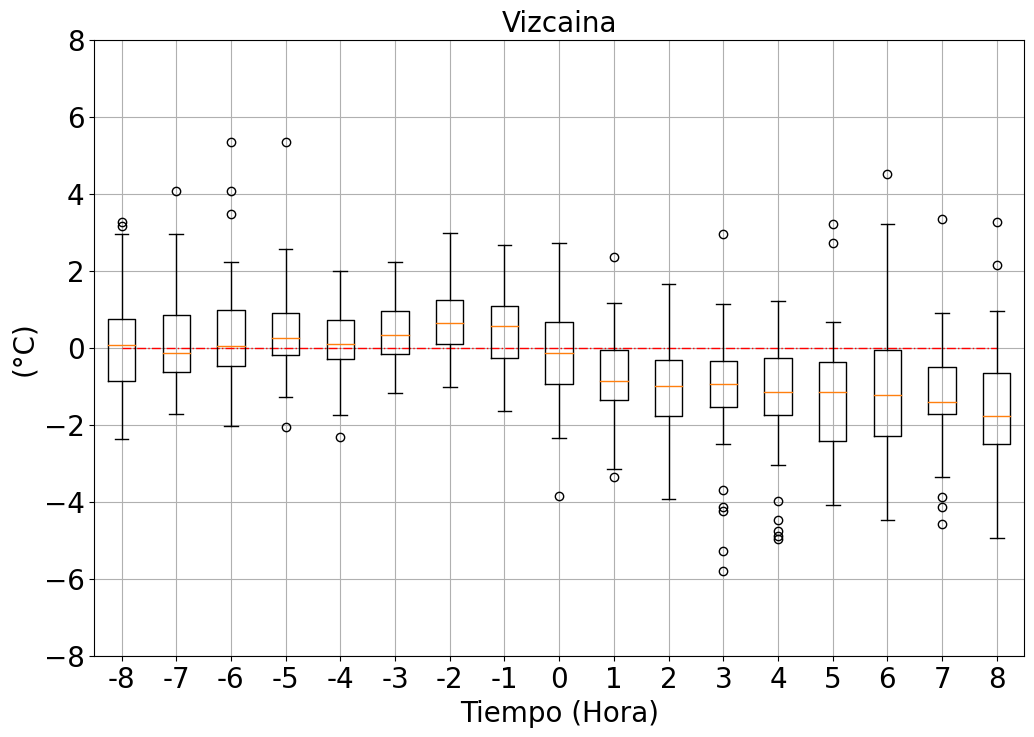

In [25]:
plot_caja_bigote(
    df=dfCross,
    columna_x="FECHA_POS",
    columna_y="TEMP_anomalia",
    titulo=NOMBRE_ESTACION.capitalize(),
    rotulo_x="Tiempo (Hora)",
    rotulo_y="(°C)",
    nombre_estacion=NOMBRE_ESTACION,
    nombre_figura="grafico_temp_caja_bigote_vizcaina_horario",
    path_para_salvar=PATH_FINAL_FIGURAS_ANOMALIAS,
    lista_xtick=label_x_values,
    ylim=[-8, 8]
)

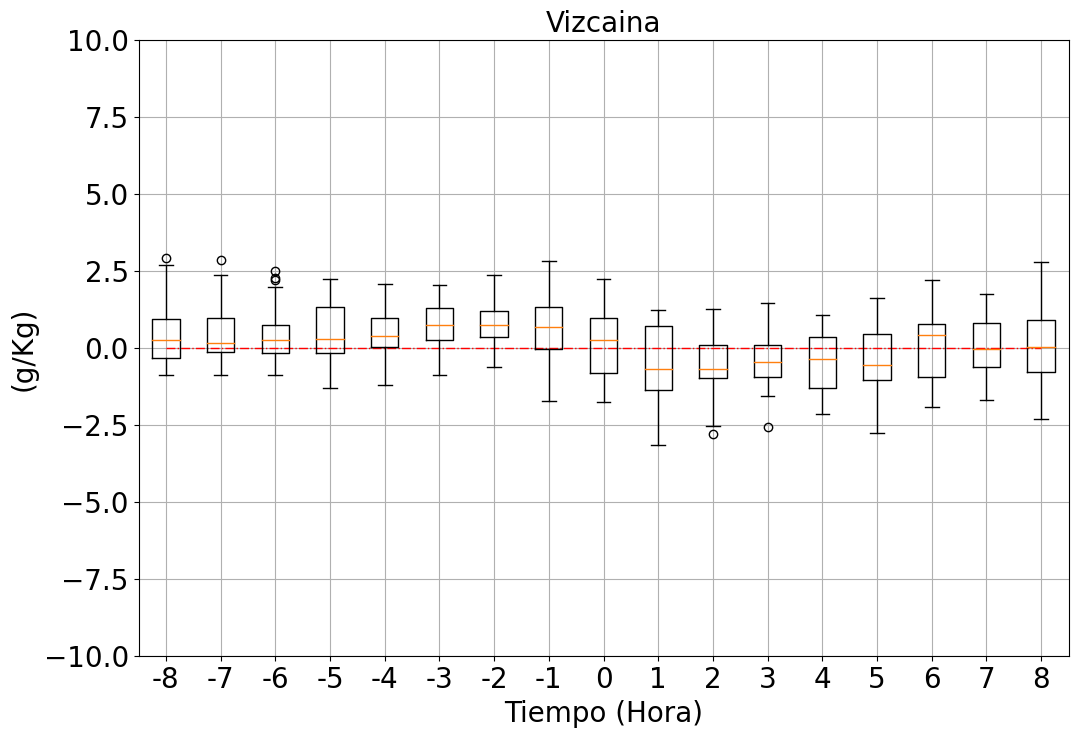

In [26]:
plot_caja_bigote(
    df=dfCross,
    columna_x="FECHA_POS",
    columna_y="HUM_ESPECIFICA_anomalia",
    titulo=NOMBRE_ESTACION.capitalize(),
    rotulo_x="Tiempo (Hora)",
    rotulo_y="(g/Kg)",
    nombre_estacion=NOMBRE_ESTACION,
    nombre_figura="grafico_hum_especifica_caja_bigote_vizcaina_horario",
    path_para_salvar=PATH_FINAL_FIGURAS_ANOMALIAS,
    lista_xtick=label_x_values,
    ylim=[-10, 10]
)

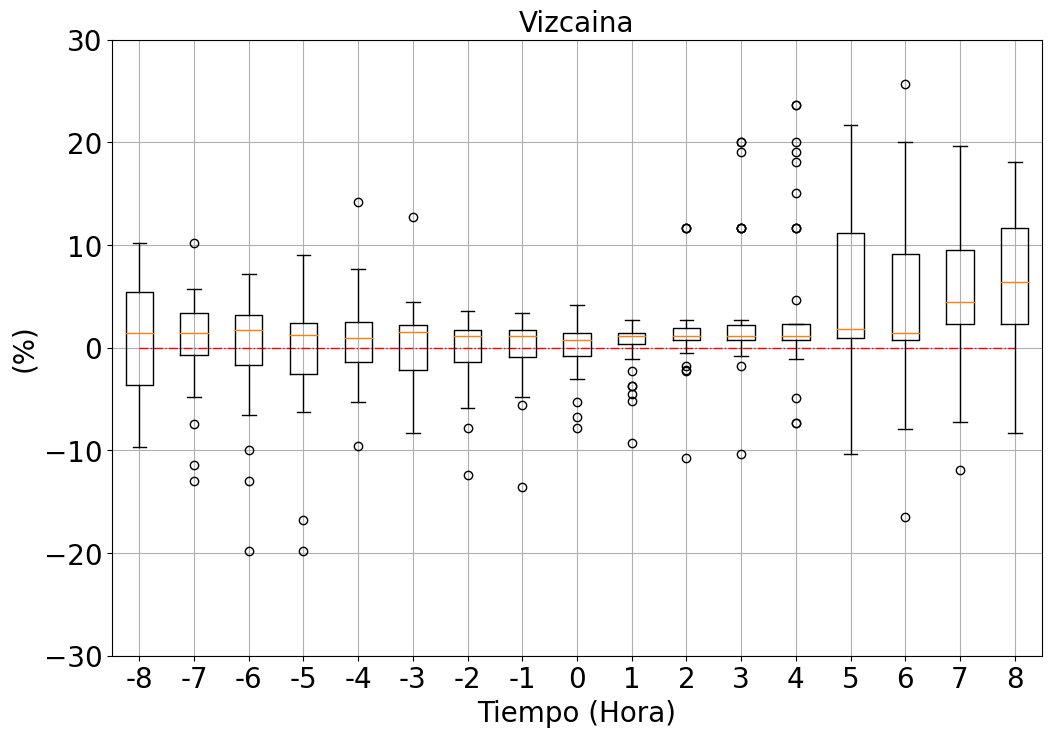

In [27]:
plot_caja_bigote(
    df=dfCross,
    columna_x="FECHA_POS",
    columna_y="HUM_anomalia",
    titulo=NOMBRE_ESTACION.capitalize(),
    rotulo_x="Tiempo (Hora)",
    rotulo_y="(%)",
    nombre_estacion=NOMBRE_ESTACION,
    nombre_figura="grafico_HUM_caja_bigote_vizcaina_horario",
    path_para_salvar=PATH_FINAL_FIGURAS_ANOMALIAS,
    lista_xtick=label_x_values,
    ylim=[-30, 30]
)

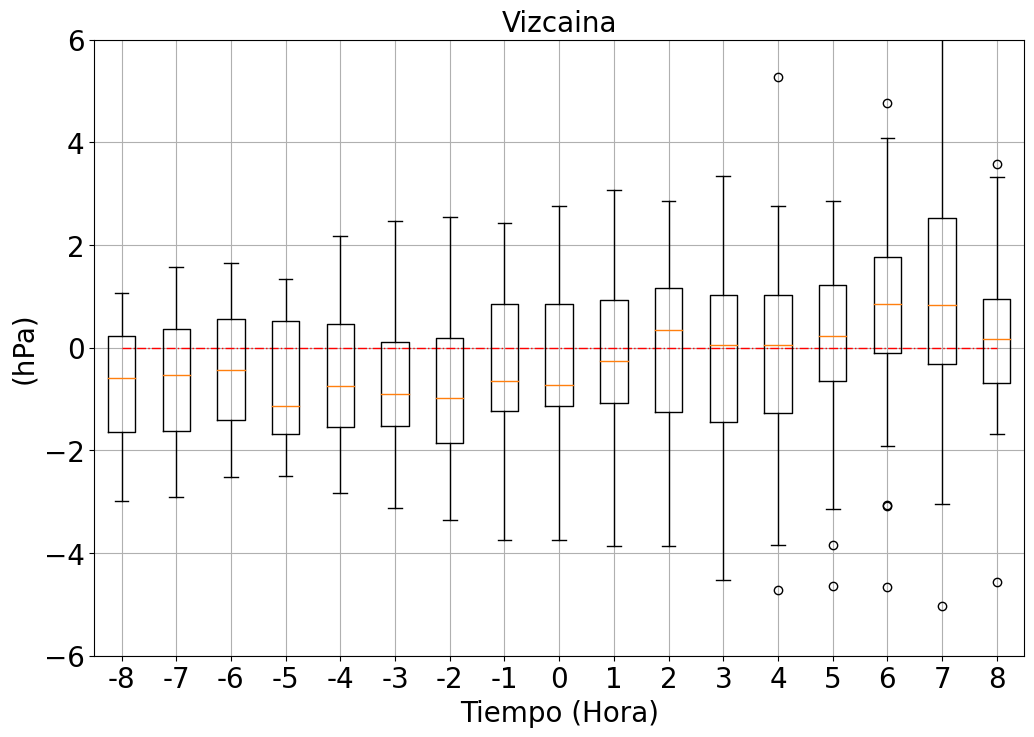

In [28]:
plot_caja_bigote(
    df=dfCross,
    columna_x="FECHA_POS",
    columna_y="PRESION_anomalia",
    titulo=NOMBRE_ESTACION.capitalize(),
    rotulo_x="Tiempo (Hora)",
    rotulo_y="(hPa)",
    nombre_estacion=NOMBRE_ESTACION,
    nombre_figura="grafico_PRESION_caja_bigote_vizcaina_horario",
    path_para_salvar=PATH_FINAL_FIGURAS_ANOMALIAS,
    lista_xtick=label_x_values,
    ylim=[-6, 6]
)

# Cargando Eventos e encontrando intervalo m minutos antes y después

In [29]:
funtimeMinutes = lambda x, minute : [x + timedelta(minutes = h) for h in (range(0, minute+1, 10) if minute > 0 else range(minute, 0, 10))]

dfEventAnMin = dfEventos.copy()

dfEventAnMin['FECHA_ANTES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = -int_minutes)
dfEventAnMin['FECHA_DESPUES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = int_minutes)

dfEventAnMin['FECHA_INTERVALO'] = dfEventAnMin['FECHA_ANTES_MIN'] + dfEventAnMin['FECHA_DESPUES_MIN']
dfEventAnMin = dfEventAnMin.drop(columns=['FECHA_ANTES_MIN', 'FECHA_DESPUES_MIN']).explode('FECHA_INTERVALO')
dfEventAnMin['FECHA_POS'] = (dfEventAnMin['FECHA_INTERVALO'] - dfEventAnMin['FECHA_MIN'])/ pd.Timedelta(minutes=1)
dfEventAnMin = dfEventAnMin.rename(columns={'FECHA_MIN' : 'FECHA_EVENTO', 'FECHA': 'FECHA_HORA', 'FECHA_INTERVALO': 'FECHA'}).reset_index(drop=True)
dfEventAnMin['FECHA'] = dfEventAnMin['FECHA'].astype(str)

dfEventAnMin.head(10)

,FECHA_HORA,FECHA_EVENTO,MIN_T,LON,LAT,FECHA,FECHA_POS
0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:20:00-05:00,-480.0
1,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:30:00-05:00,-470.0
2,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:40:00-05:00,-460.0
3,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:50:00-05:00,-450.0
4,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:00:00-05:00,-440.0
5,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:10:00-05:00,-430.0
6,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:20:00-05:00,-420.0
7,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:30:00-05:00,-410.0
8,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:40:00-05:00,-400.0
9,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:50:00-05:00,-390.0


In [30]:
dfCrossPrec = pd.merge(dfEventAnMin, dfPrec, on='FECHA', how = 'left')

dfCrossPrecGroup = dfCrossPrec.groupby("FECHA_POS").agg({"PREC" : ["mean", "std"]})
dfCrossPrecGroup = dfCrossPrecGroup.rename(columns = {("PREC", "mean") : "PREC_mean", ("PREC", "std") : "PREC_std"}).reset_index()

dfCrossPrecGroup

FECHA_POS      PREC          
                  mean       std
0     -480.0  0.000000  0.000000
1     -470.0  0.000000  0.000000
2     -460.0  0.000000  0.000000
3     -450.0  0.000000  0.000000
4     -440.0  0.000000  0.000000
..       ...       ...       ...
92     440.0  0.069565  0.239323
93     450.0  0.056522  0.264703
94     460.0  0.110638  0.461677
95     470.0  0.076596  0.328510
96     480.0  0.108511  0.466173

[97 rows x 3 columns]

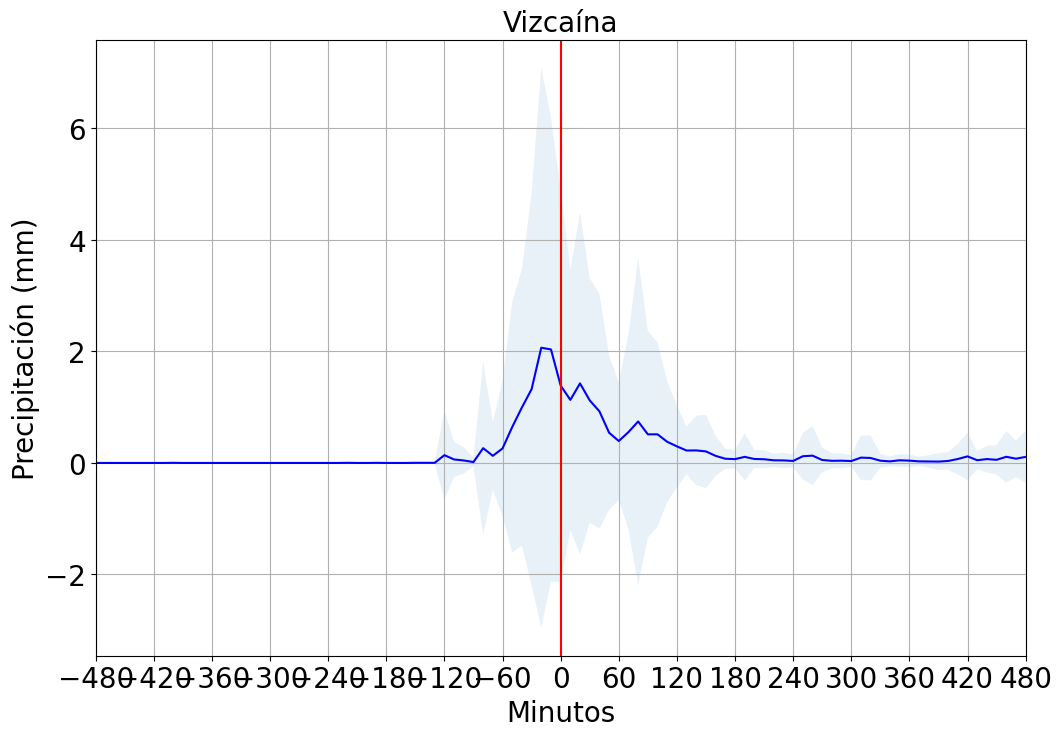

In [31]:
def plot_10m_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  if has_std:
    plt.plot(df['FECHA_POS'], df[(campo, 'mean')], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[(campo, 'mean')] + df[(campo, 'std')], df[(campo, 'mean')] - df[(campo, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  # plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'PREC' : {'title' : 'Análisis de Precipitación de eventos convectivos', 'name2save' : f'analisis_prec_20h_7h_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Precipitación (mm)'},

    }

for key in dict_names.keys():
  plot_10m_interval(dfCrossPrecGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes)


In [32]:
df10m

,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,FECHA
0,2011-01-02 00,-0.063847,-0.596293,00,2011-01-02 00:00:00-05:00
1,2011-01-02 01,-0.076218,-0.559301,01,2011-01-02 01:00:00-05:00
2,2011-01-02 02,-0.034522,-0.431268,02,2011-01-02 02:00:00-05:00
3,2011-01-02 03,-0.077836,-0.493173,03,2011-01-02 03:00:00-05:00
4,2011-01-02 04,-0.127415,-0.483384,04,2011-01-02 04:00:00-05:00
...,...,...,...,...,...
24116,2017-12-31 19,-0.258113,0.324864,19,2017-12-31 19:00:00-05:00
24117,2017-12-31 20,0.026130,0.282996,20,2017-12-31 20:00:00-05:00
24118,2017-12-31 21,0.014230,0.216092,21,2017-12-31 21:00:00-05:00
24119,2017-12-31 22,0.487289,0.111343,22,2017-12-31 22:00:00-05:00


# Análisis para Dirección del Viento

In [33]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

# df10mean['DIRVIENTO_mean'] = df10mean.apply(func_dir, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
# df10mean['VELVIENTO_mean'] = df10mean.apply(func_vel, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
df10m['DIRVIENTO'] = df10m.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
df10m['VELVIENTO'] = df10m.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

# Análisis de percentiles - Precipitación

In [67]:
def plot_percentil_interval_prec(df, campos, campo_analizar, titulo, name_to_save, ylabel_name, int_minutes, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0

  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency],fontsize=15)
  plt.yticks(fontsize=20)
  if not .5 in campos:
    campos.append(.5)
  #for campo in campos:
    #plt.plot(df['FECHA_POS'], df[campo], label = f"Percentil {campo}")
  #plt.plot(df['FECHA_POS'], df[.5], label = f"Percentil")
  ## Gráfica del promedio
  plt.plot(df['FECHA_POS'], df[(campo_analizar, 'mean')], linestyle = '--')

  ## Gráfica de la desviación standard
  plt.fill_between(df['FECHA_POS'], df[campos[0]] , df[campos[1]], alpha=.1, linestyle = '--', linewidth = 0.5)

  plt.axvline(color = 'r')
  plt.grid()
  plt.xlim([-int_minutes, int_minutes])
  plt.ylim(0,2.2)
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize=15)
  plt.ylabel(ylabel_name, fontsize=20)
  plt.title("Vizcaína", fontsize=20)
  plt.legend()

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )


<ipython-input-68-714a6fe0d391>:7: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dfPercentilPrec = dfPercentilPrec.join(dfAggPrec, "FECHA_POS")


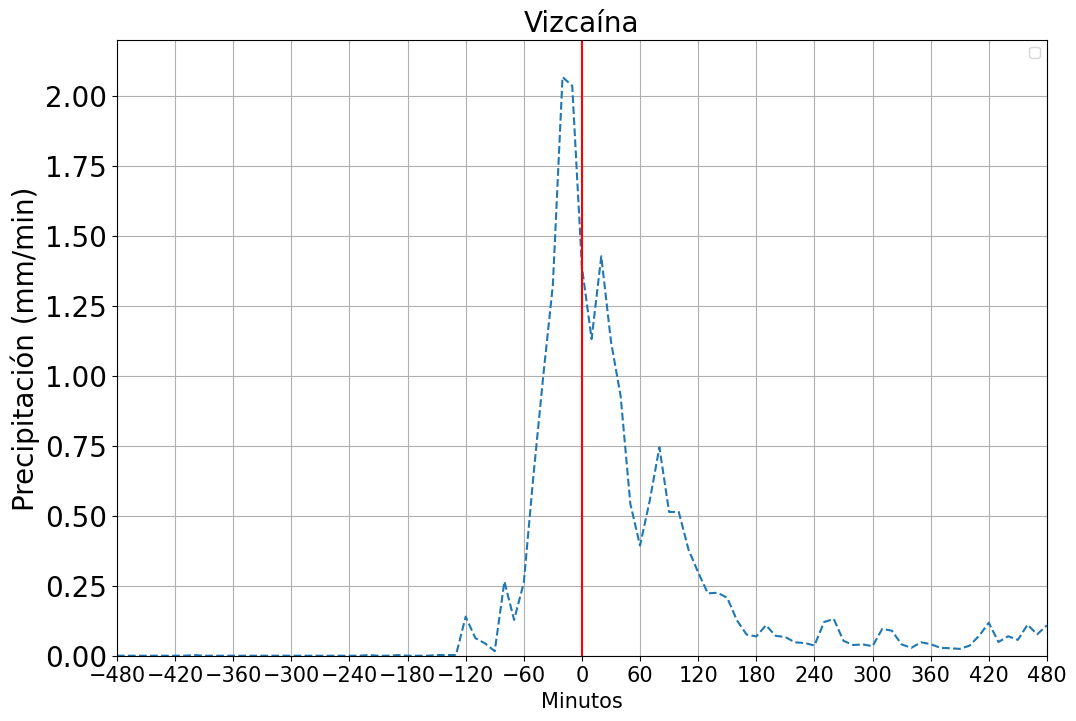

In [68]:
list_percentil = [ 0.05, .1, .20, .25, .50, .75, .80, .90, 0.95]
dfCrossPrecNotNan = dfCrossPrec.dropna().reset_index()
dfPercentilPrec= dfCrossPrecNotNan.groupby("FECHA_POS")['PREC'].quantile(list_percentil).reset_index()
dfAggPrec = dfCrossPrecNotNan.groupby("FECHA_POS").agg({"PREC" : ["mean", "std"]})

dfPercentilPrec = dfPercentilPrec.pivot(index='FECHA_POS', columns='level_1')['PREC'].reset_index()
dfPercentilPrec = dfPercentilPrec.join(dfAggPrec, "FECHA_POS")

dict_names = {'title' : 'Análisis de precipitación',
              'name2save' : f'analisis_precipitacion_percentil_20h_7h_{NOMBRE_ESTACION}_{int_minutes}m.png',
              'ylabel' : 'Precipitación (mm/min)'
              }

plot_percentil_interval_prec(dfPercentilPrec, [.50, .50], 'PREC', dict_names['title'], dict_names['name2save'], dict_names['ylabel'], int_minutes)

# Análisis de Viento

In [36]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

In [37]:
dfEventAnMin['HORA_MINUTO'] = dfEventAnMin['FECHA'].apply(lambda x: x[11:16])
dfEventAnMin


,FECHA_HORA,FECHA_EVENTO,MIN_T,LON,LAT,FECHA,FECHA_POS,HORA_MINUTO
0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:20:00-05:00,-480.0,21:20
1,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:30:00-05:00,-470.0,21:30
2,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:40:00-05:00,-460.0,21:40
3,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:50:00-05:00,-450.0,21:50
4,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:00:00-05:00,-440.0,22:00
...,...,...,...,...,...,...,...,...
5912,2017-11-25 03:00:00-05:00,2017-11-25 02:40:00-05:00,204.4,-73.693,7.058,2017-11-25 10:00:00-05:00,440.0,10:00
5913,2017-11-25 03:00:00-05:00,2017-11-25 02:40:00-05:00,204.4,-73.693,7.058,2017-11-25 10:10:00-05:00,450.0,10:10
5914,2017-11-25 03:00:00-05:00,2017-11-25 02:40:00-05:00,204.4,-73.693,7.058,2017-11-25 10:20:00-05:00,460.0,10:20
5915,2017-11-25 03:00:00-05:00,2017-11-25 02:40:00-05:00,204.4,-73.693,7.058,2017-11-25 10:30:00-05:00,470.0,10:30


In [38]:
dfViento['HORA_MINUTO'] = dfViento['FECHA'].apply(lambda x: x[11:16])
dfViento

dfVientoMean = dfViento.groupby('HORA_MINUTO').agg('mean').reset_index(level=0)
dfVientoMean = dfVientoMean.rename(columns={"VELVIENTO":"VELVIENTO_mean"})


<ipython-input-38-23248fbf0cea>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfVientoMean = dfViento.groupby('HORA_MINUTO').agg('mean').reset_index(level=0)


In [39]:
dfCrossVientos = pd.merge(dfEventAnMin[['HORA_MINUTO', 'FECHA_POS', 'FECHA']], dfViento[[col for col in dfViento.columns if col != "HORA_MINUTO" ]], on='FECHA', how = 'left')
dfCrossVientos = pd.merge(dfCrossVientos, dfVientoMean[['HORA_MINUTO', 'VELVIENTO_mean']], on='HORA_MINUTO', how = 'left')

### Cálculo de la anomalia
dfCrossVientos['VEL_VIENTO_anomalia'] = dfCrossVientos['VELVIENTO'] - dfCrossVientos['VELVIENTO_mean']

dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"VEL_VIENTO_anomalia" : ["mean", "std"]}).reset_index()
# dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"VEL_VIENTO_anomalia" : "mean", "VEL_VIENTO_anomalia" : "std"}).reset_index()
# dfCrossVientosGroup
# dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"VELVIENTO" : ["mean", "std"]}).reset_index()

dfCrossVientosGroup2 = pd.DataFrame()
dfCrossVientosGroup2['FECHA_POS'] = dfCrossVientosGroup[('FECHA_POS',     '')]
dfCrossVientosGroup2['VEL_VIENTO_STD'] = dfCrossVientosGroup[("VEL_VIENTO_anomalia", "std") ]
dfCrossVientosGroup2['VEL_VIENTO_MEAN'] = dfCrossVientosGroup[("VEL_VIENTO_anomalia", "mean") ]

In [40]:
dfCrossVientos

,HORA_MINUTO,FECHA_POS,FECHA,DIRECVIENTO,VELVIENTO,FECHA_HORA,X_VIENTO,Y_VIENTO,VELVIENTO_mean,VEL_VIENTO_anomalia
0,21:20,-480.0,2011-02-12 21:20:00-05:00,11.0,0.4,2011-02-12 21,-0.076324,-0.392651,0.766103,-0.366103
1,21:30,-470.0,2011-02-12 21:30:00-05:00,12.0,0.4,2011-02-12 21,-0.083165,-0.391259,0.776874,-0.376874
2,21:40,-460.0,2011-02-12 21:40:00-05:00,11.0,1.0,2011-02-12 21,-0.190809,-0.981627,0.774789,0.225211
3,21:50,-450.0,2011-02-12 21:50:00-05:00,9.0,0.7,2011-02-12 21,-0.109504,-0.691382,0.775316,-0.075316
4,22:00,-440.0,2011-02-12 22:00:00-05:00,10.0,0.7,2011-02-12 22,-0.121554,-0.689365,0.791897,-0.091897
...,...,...,...,...,...,...,...,...,...,...
5912,10:00,440.0,2017-11-25 10:00:00-05:00,156.0,1.0,2017-11-25 10,-0.406737,0.913545,1.203162,-0.203162
5913,10:10,450.0,2017-11-25 10:10:00-05:00,329.0,0.6,2017-11-25 10,0.309023,-0.514300,1.212512,-0.612512
5914,10:20,460.0,2017-11-25 10:20:00-05:00,185.0,0.8,2017-11-25 10,0.069725,0.796956,1.213452,-0.413452
5915,10:30,470.0,2017-11-25 10:30:00-05:00,73.0,0.9,2017-11-25 10,-0.860674,-0.263135,1.236004,-0.336004


In [41]:
cols_vientos = ["VELVIENTO", "DIRECVIENTO"]

dfEventos0Vientos = dfCrossVientos.loc[dfCrossVientos['FECHA_POS'] == 0.].copy()
dfEventos0Vientos['NUMERO_VARS'] = dfEventos0Vientos[cols_vientos].notnull().sum(axis=1)
dfEventos0Vientos.count()

HORA_MINUTO            61
FECHA_POS              61
FECHA                  61
DIRECVIENTO            19
VELVIENTO              19
FECHA_HORA             19
X_VIENTO               19
Y_VIENTO               19
VELVIENTO_mean         61
VEL_VIENTO_anomalia    19
NUMERO_VARS            61
dtype: int64

In [42]:
cols_prec = ["PREC"]

dfEventos0Prec = dfCrossPrec.loc[dfCrossPrec['FECHA_POS'] == 0.].copy()
dfEventos0Prec['NUMERO_VARS'] = dfEventos0Prec[cols_prec].notnull().sum(axis=1)
dfEventos0Prec.count()


FECHA_HORA      61
FECHA_EVENTO    61
MIN_T           61
LON             61
LAT             61
FECHA           61
FECHA_POS       61
PREC            45
NUMERO_VARS     61
dtype: int64

In [43]:
# dfCrossVientos = pd.merge(dfEventAnMin, dfViento, on='FECHA', how = 'left')
# dfCrossVientos = dfCrossVientos.loc[dfCrossVientos['FECHA_POS'] == 240]
# dfCrossVientos["X_VIENTO_STD"] = dfCrossVientos["X_VIENTO"]
# dfCrossVientos["Y_VIENTO_STD"] = dfCrossVientos["Y_VIENTO"]


# dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"VELVIENTO" : ["mean", "std"]}).reset_index()
# dfCrossVientosGroup = dfCrossVientosGroup.rename(columns = {("VELVIENTO", "mean") : "VEL_VIENTO_mean", ("VELVIENTO", "std") : "VEL_VIENTO_std", ('FECHA_POS',     '') : "FECHA_POS"})
# dfCrossVientosGroup2 = pd.DataFrame()
# dfCrossVientosGroup2['FECHA_POS'] = dfCrossVientosGroup[('FECHA_POS',     '')]
# dfCrossVientosGroup2['VEL_VIENTO_STD'] = dfCrossVientosGroup[("VELVIENTO", "std") ]
# dfCrossVientosGroup2['VEL_VIENTO_MEAN'] = dfCrossVientosGroup[("VELVIENTO", "mean") ]

# dfCrossVientosGroup.rename(columns = {("VELVIENTO", "mean") : "VEL_VIENTO_mean", ("VELVIENTO", "std") : "VEL_VIENTO_std", ('FECHA_POS',     '') : "FECHA_POS"})

# dfCrossVientosGroup['DIR_VIENTO'] = dfCrossVientosGroup.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
# dfCrossVientosGroup['DIR_VIENTO'] = (dfCrossVientosGroup['DIR_VIENTO'] + 180.0) % 360
# dfCrossVientosGroup['VEL_VIENTO'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
# dfCrossVientosGroup['VEL_VIENTO_MEAN'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
# dfCrossVientosGroup['VEL_VIENTO_STD'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO_STD', y='Y_VIENTO_STD', axis=1)


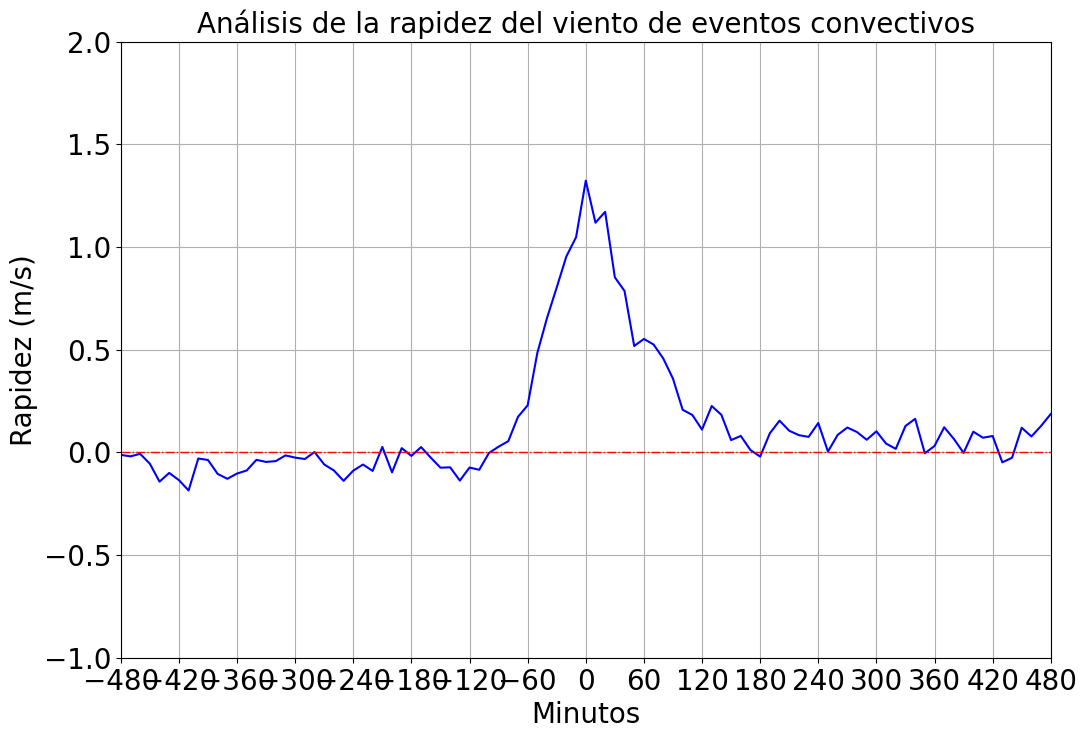

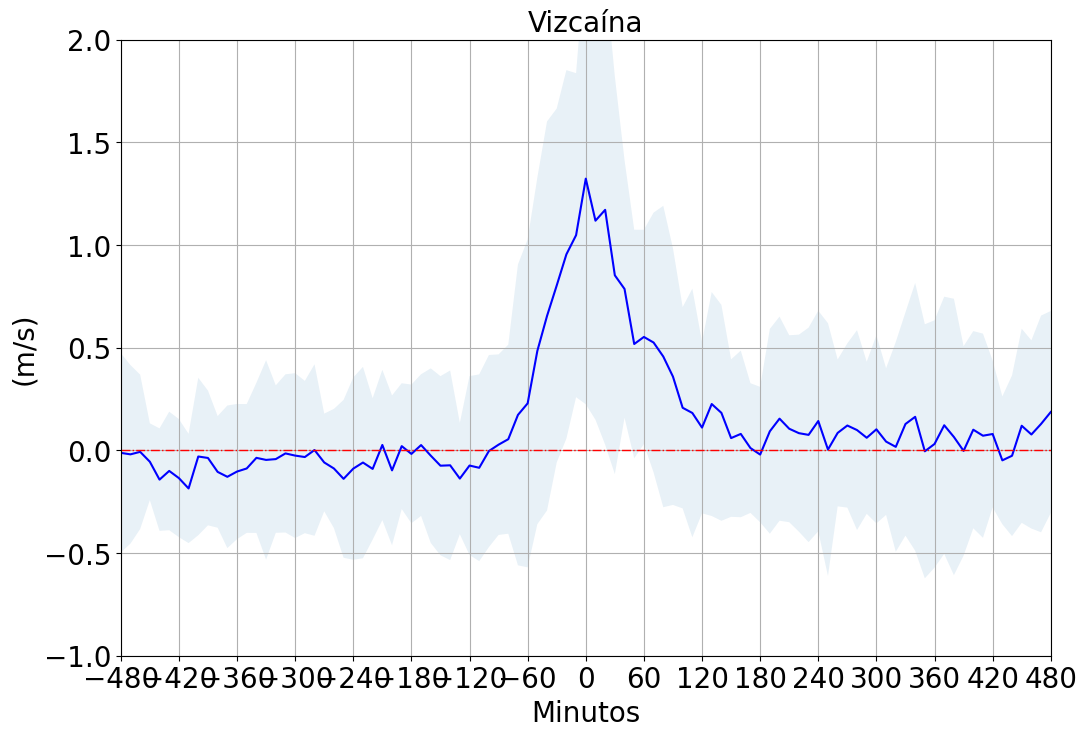

In [44]:
def plot_10m_interval_v2(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  if has_std:
    plt.plot(df['FECHA_POS'], df[f"{campo}_MEAN"], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[f"{campo}_MEAN"] + df[f"{campo}_STD"], df[f"{campo}_MEAN"] - df[f"{campo}_STD"], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[f"{campo}_MEAN"], color = 'b')
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  # plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title(titulo, fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

def plot_dir_viento_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  plt.yticks(range(0, 361, 45))
  if has_std:
    plt.plot(df['FECHA_POS'], df[f"{campo}_MEAN"], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[f"{campo}_MEAN"] + df[f"{campo}_STD"], df[f"{campo}_MEAN"] - df[f"{campo}_STD"], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 25)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'DIR_VIENTO' : {'title' : 'Análisis de la dirección del viento de eventos convectivos', 'name2save' : f'analisis_dir_viento_20h_7h_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Dirección (°)'},
              'VEL_VIENTO' : {'title' : 'Análisis de la rapidez del viento de eventos convectivos', 'name2save' : f'analisis_vel_viento_20h_7h_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Rapidez (m/s)'},
              'VEL_VIENTO_2' : {'title' : 'Vizcaína', 'name2save' : f'analisis_vel_viento_std_20h_7h_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : '(m/s)'},
             }

# key = 'DIR_VIENTO'
# plot_dir_viento_interval(dfCrossVientosGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, ylimit = [0, 360], has_std=False)

key = 'VEL_VIENTO'
plot_10m_interval_v2(dfCrossVientosGroup2, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, ylimit=[-1, 2], has_std=False)

key = 'VEL_VIENTO_2'
plot_10m_interval_v2(dfCrossVientosGroup2, 'VEL_VIENTO', dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, ylimit=[-1, 2], has_std=True)

## Anáisis de Percentiles

In [45]:
dfCrossVientos

,HORA_MINUTO,FECHA_POS,FECHA,DIRECVIENTO,VELVIENTO,FECHA_HORA,X_VIENTO,Y_VIENTO,VELVIENTO_mean,VEL_VIENTO_anomalia
0,21:20,-480.0,2011-02-12 21:20:00-05:00,11.0,0.4,2011-02-12 21,-0.076324,-0.392651,0.766103,-0.366103
1,21:30,-470.0,2011-02-12 21:30:00-05:00,12.0,0.4,2011-02-12 21,-0.083165,-0.391259,0.776874,-0.376874
2,21:40,-460.0,2011-02-12 21:40:00-05:00,11.0,1.0,2011-02-12 21,-0.190809,-0.981627,0.774789,0.225211
3,21:50,-450.0,2011-02-12 21:50:00-05:00,9.0,0.7,2011-02-12 21,-0.109504,-0.691382,0.775316,-0.075316
4,22:00,-440.0,2011-02-12 22:00:00-05:00,10.0,0.7,2011-02-12 22,-0.121554,-0.689365,0.791897,-0.091897
...,...,...,...,...,...,...,...,...,...,...
5912,10:00,440.0,2017-11-25 10:00:00-05:00,156.0,1.0,2017-11-25 10,-0.406737,0.913545,1.203162,-0.203162
5913,10:10,450.0,2017-11-25 10:10:00-05:00,329.0,0.6,2017-11-25 10,0.309023,-0.514300,1.212512,-0.612512
5914,10:20,460.0,2017-11-25 10:20:00-05:00,185.0,0.8,2017-11-25 10,0.069725,0.796956,1.213452,-0.413452
5915,10:30,470.0,2017-11-25 10:30:00-05:00,73.0,0.9,2017-11-25 10,-0.860674,-0.263135,1.236004,-0.336004


In [46]:
def plot_percentil_interval(df, campos, campo_analizar, titulo, name_to_save, ylabel_name, int_minutes, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0

  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  if not .5 in campos:
    campos.append(.5)
  #for campo in campos:
    #plt.plot(df['FECHA_POS'], df[campo], label = f"Percentil {campo}")
  # plt.plot(df['FECHA_POS'], df[0.5], label = f"Percentil {0.5}")
  ## Gráfica del promedio
  plt.plot(df['FECHA_POS'], df[(campo_analizar, 'mean')], color = 'b')

  ## Gráfica de la desviación standard
  plt.fill_between(df['FECHA_POS'], df[campos[0]] , df[campos[1]], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)


  # plt.axvline(color = 'r')
  plt.grid()
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)
  plt.legend()

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )


<ipython-input-47-da081ed593c0>:6: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dfPercentilViento = dfPercentilViento.join(dfAggViento, "FECHA_POS")


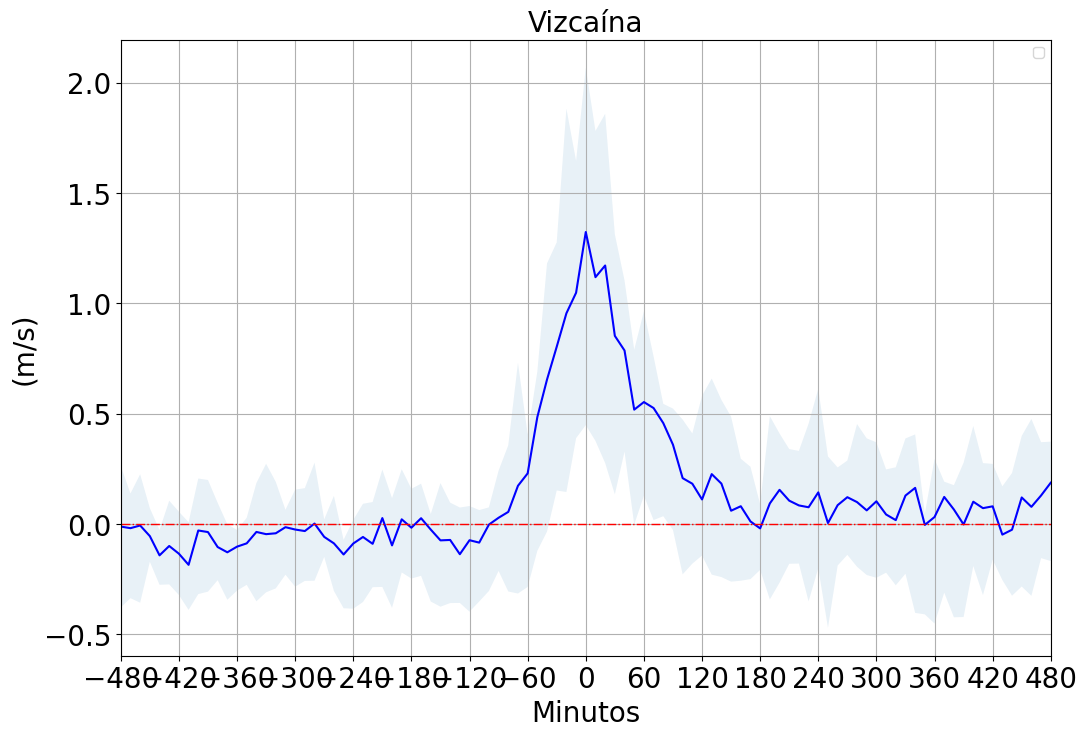

In [47]:
list_percentil = [.10, .20,.25, .50, .75, .80, .90]
dfPercentilViento = dfCrossVientos.groupby("FECHA_POS")['VEL_VIENTO_anomalia'].quantile(list_percentil).reset_index()
dfAggViento = dfCrossVientos.groupby("FECHA_POS").agg({"VEL_VIENTO_anomalia" : ["mean", "std"]})

dfPercentilViento = dfPercentilViento.pivot(index='FECHA_POS', columns='level_1')['VEL_VIENTO_anomalia'].reset_index()
dfPercentilViento = dfPercentilViento.join(dfAggViento, "FECHA_POS")

dict_names = {'title' : 'Vizcaina',
              'name2save' : f'analisis_rapidez_viento_percentil_20h_7h_{NOMBRE_ESTACION}_{int_minutes}_anomalia_mean.png',
              'ylabel' : '(m/s)'
              }

plot_percentil_interval(dfPercentilViento, [.25, .75], 'VEL_VIENTO_anomalia', dict_names['title'], dict_names['name2save'], dict_names['ylabel'], int_minutes)

In [48]:
dfPercentilViento

,FECHA_POS,0.1,0.2,0.25,0.5,0.75,0.8,0.9,"(VEL_VIENTO_anomalia, mean)","(VEL_VIENTO_anomalia, std)",CERO
0,-480,-0.475859,-0.420065,-0.378744,-0.193916,0.262509,0.334383,0.641686,-0.011994,0.485239,0
1,-470,-0.428099,-0.367042,-0.336519,-0.114010,0.137851,0.284782,0.655268,-0.019269,0.434668,0
2,-460,-0.424864,-0.418006,-0.357142,-0.024896,0.225211,0.235496,0.309494,-0.007061,0.375857,0
3,-450,-0.297861,-0.215093,-0.171296,-0.089552,0.071426,0.101906,0.166603,-0.055216,0.186990,0
4,-440,-0.490323,-0.319504,-0.275877,-0.099386,-0.027693,0.015686,0.087783,-0.142371,0.249507,0
...,...,...,...,...,...,...,...,...,...,...,...
92,440,-0.437863,-0.404345,-0.325441,-0.151434,0.230714,0.338543,0.519510,-0.026171,0.391208,0
93,450,-0.413096,-0.332863,-0.283722,0.163317,0.398865,0.442853,0.640232,0.119954,0.472680,0
94,460,-0.472156,-0.418452,-0.325971,0.018627,0.475633,0.577329,0.689179,0.077495,0.458227,0
95,470,-0.346004,-0.234219,-0.154997,0.040797,0.370512,0.402019,0.593782,0.128984,0.527642,0


# Análisis de viento por hora

In [49]:
dfCrossVientosHora = pd.merge(dfEventAn, df10m, on='FECHA', how = 'left')

dfCrossVientosHora
# dfCrossVientosHoraGroup = dfCrossVientosHora.groupby("FECHA_POS").agg({"X_VIENTO" : "mean", "Y_VIENTO" : "mean"}).reset_index()

dfCrossVientosHora['DIR_VIENTO'] = dfCrossVientosHora.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosHora['DIR_VIENTO'] = (dfCrossVientosHora['DIR_VIENTO'] + 180.0) % 360
dfCrossVientosHora['VEL_VIENTO'] = dfCrossVientosHora.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

dfCrossVientosHora

,index,FECHA_EVENTO,FECHA_MIN,MIN_T,LON,LAT,FECHA,FECHA_POS,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,DIRVIENTO,VELVIENTO,DIR_VIENTO,VEL_VIENTO
0,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:00:00-05:00,-8.0,2011-02-12 21,-0.115430,-0.639563,21,190.230764,0.649896,10.230764,0.649896
1,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:00:00-05:00,-7.0,2011-02-12 22,-0.165177,-0.833039,22,191.215285,0.849257,11.215285,0.849257
2,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 23:00:00-05:00,-6.0,2011-02-12 23,-0.132984,-0.687190,23,190.952379,0.699939,10.952379,0.699939
3,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 00:00:00-05:00,-5.0,2011-02-13 00,-0.090980,-0.593018,00,188.722257,0.599956,8.722257,0.599956
4,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:00:00-05:00,-4.0,2011-02-13 01,-0.059542,-0.680530,01,185.000297,0.683130,5.000297,0.683130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,60,2017-11-25 03:00:00-05:00,2017-11-25 02:40:00-05:00,204.4,-73.693,7.058,2017-11-25 07:00:00-05:00,4.0,2017-11-25 07,-0.230009,0.641006,07,340.260765,0.681024,160.260765,0.681024
1033,60,2017-11-25 03:00:00-05:00,2017-11-25 02:40:00-05:00,204.4,-73.693,7.058,2017-11-25 08:00:00-05:00,5.0,2017-11-25 08,0.508155,0.386995,08,52.708243,0.638738,232.708243,0.638738
1034,60,2017-11-25 03:00:00-05:00,2017-11-25 02:40:00-05:00,204.4,-73.693,7.058,2017-11-25 09:00:00-05:00,6.0,2017-11-25 09,-0.090942,0.417721,09,347.717778,0.427506,167.717778,0.427506
1035,60,2017-11-25 03:00:00-05:00,2017-11-25 02:40:00-05:00,204.4,-73.693,7.058,2017-11-25 10:00:00-05:00,7.0,2017-11-25 10,-0.030787,-0.158300,10,191.005700,0.161266,11.005700,0.161266


In [50]:
def plot_windrose(df, title, path_to_save):
  ax = WindroseAxes.from_ax()

  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, bins=np.arange(0.0, 5, 0.5), edgecolor='white', cmap=cm.cool)
  ax.set_legend(loc = 3)
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
  plt.title(title)
  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
  plt.show()

In [51]:
posHoras = set(list(dfCrossVientosHora['FECHA_POS']))
posHoras

{-8.0,
 -7.0,
 -6.0,
 -5.0,
 -4.0,
 -3.0,
 -2.0,
 -1.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0}

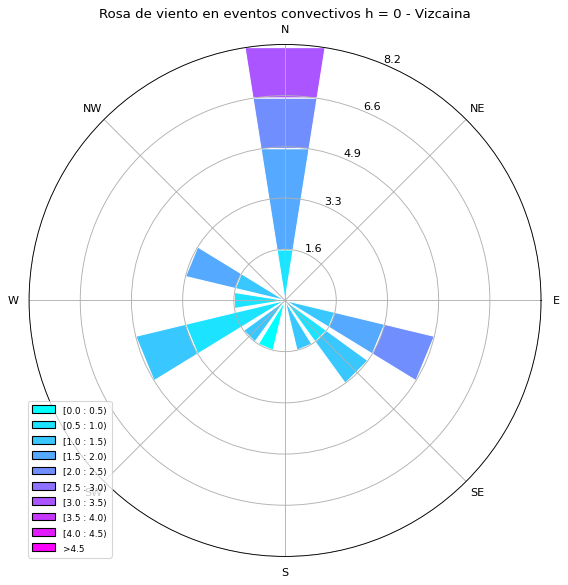

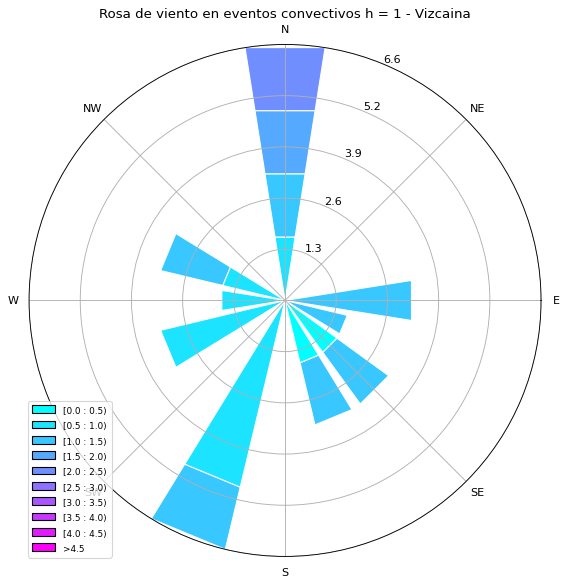

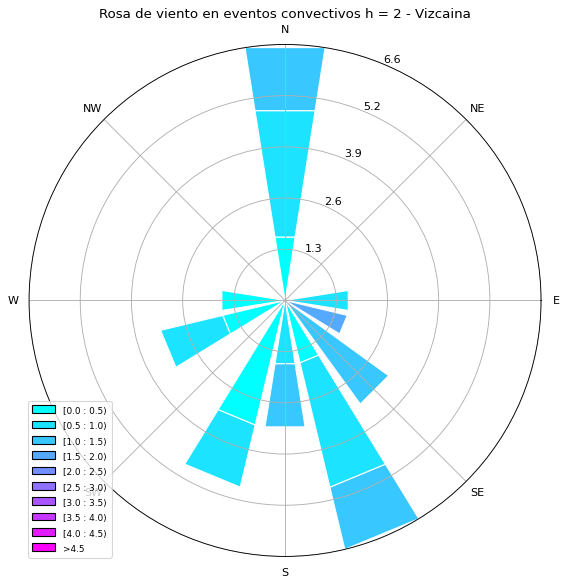

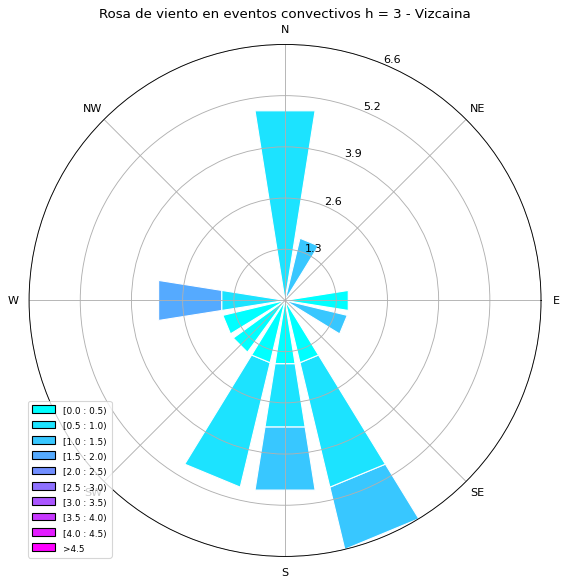

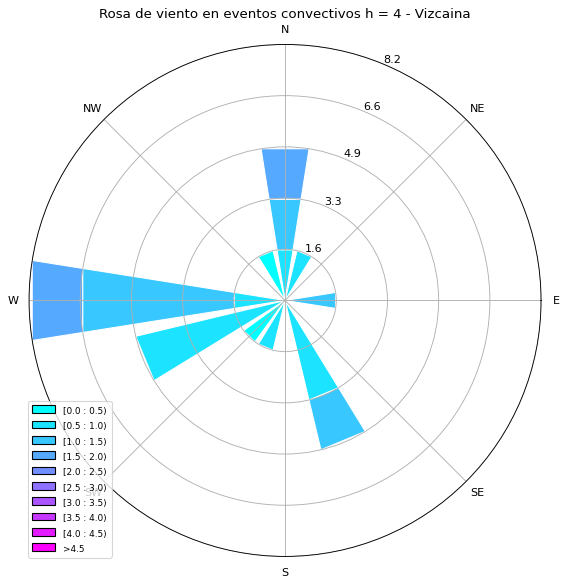

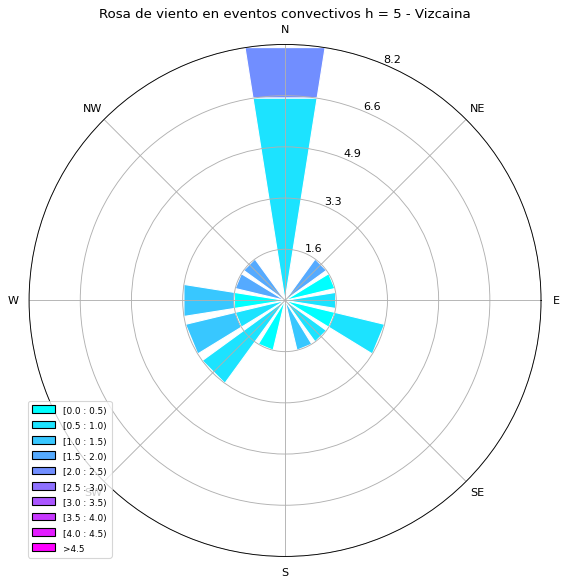

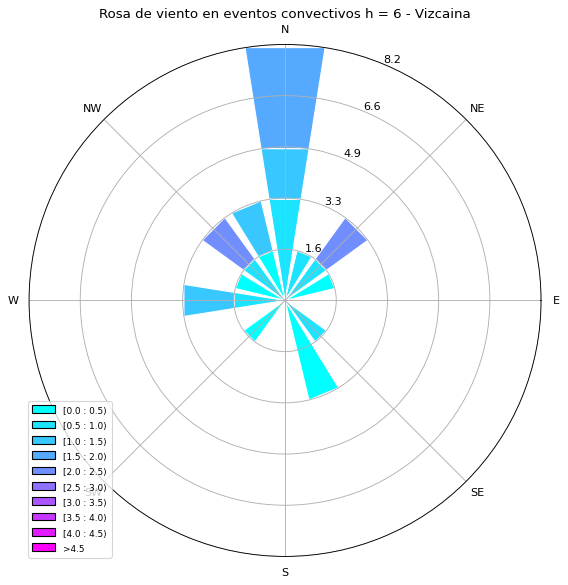

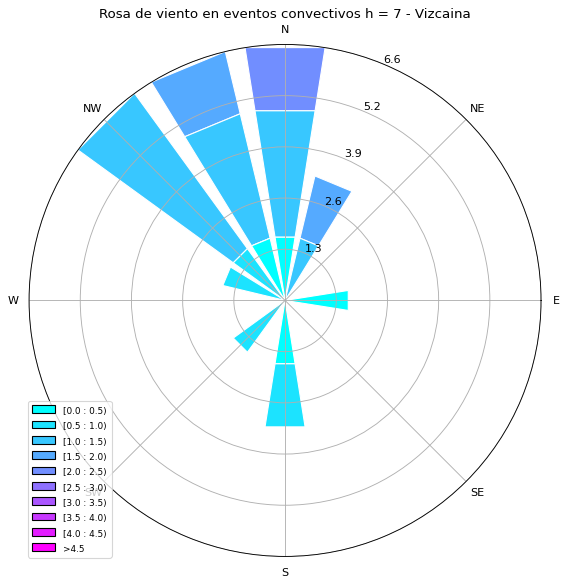

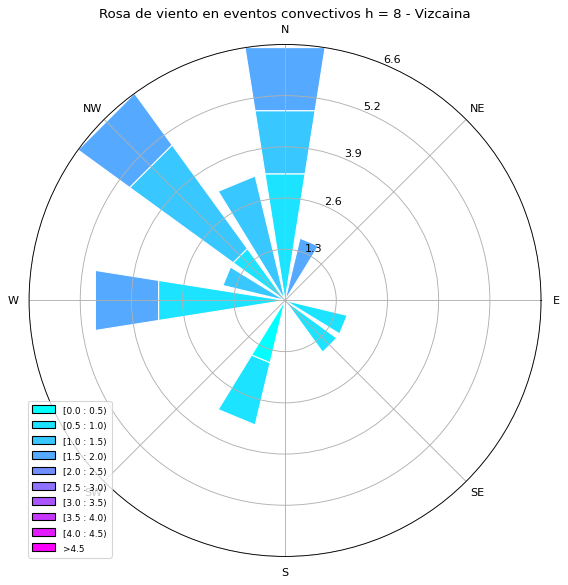

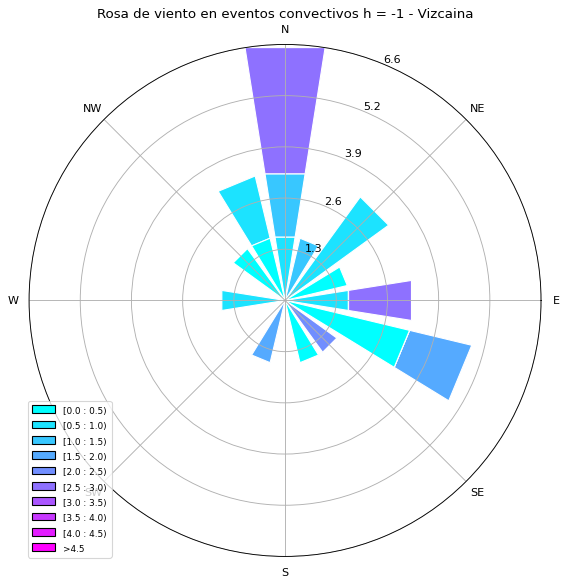

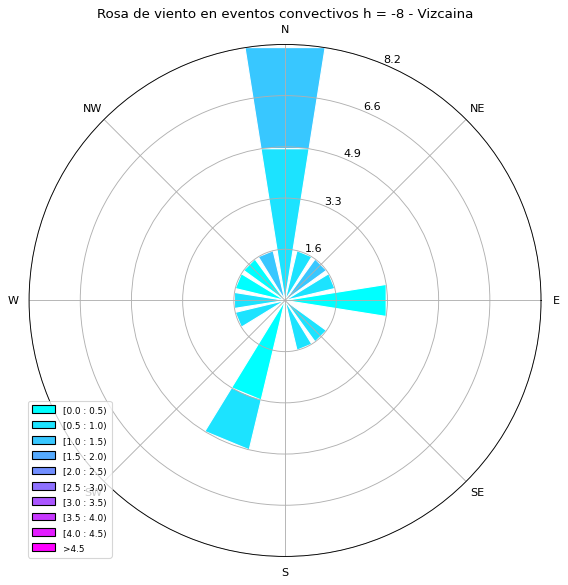

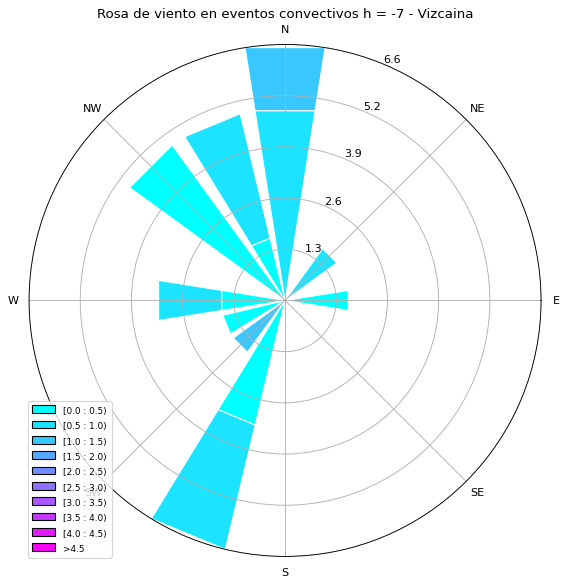

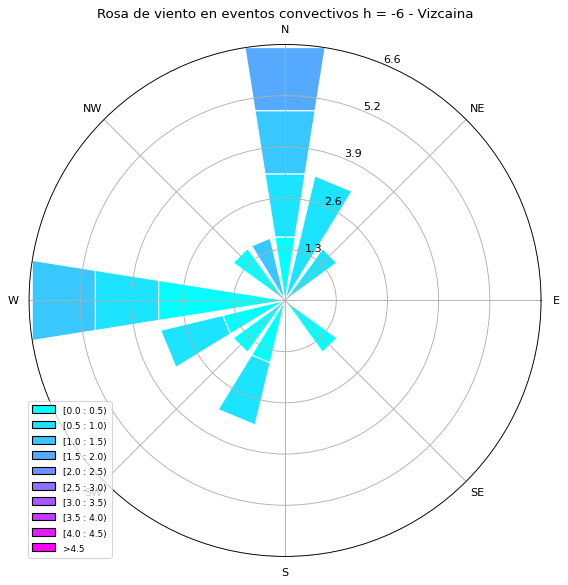

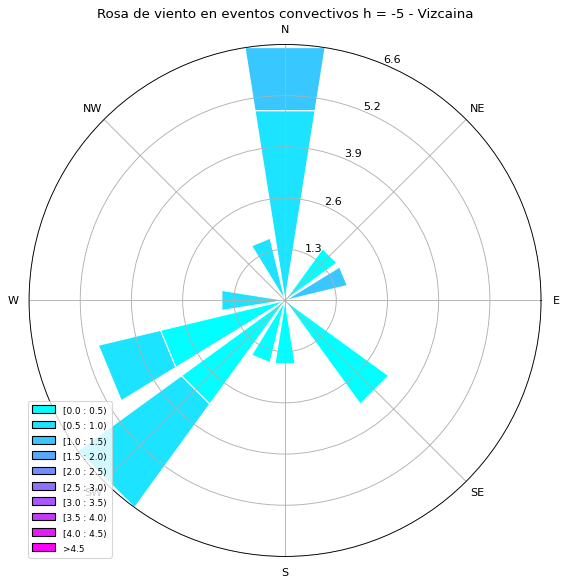

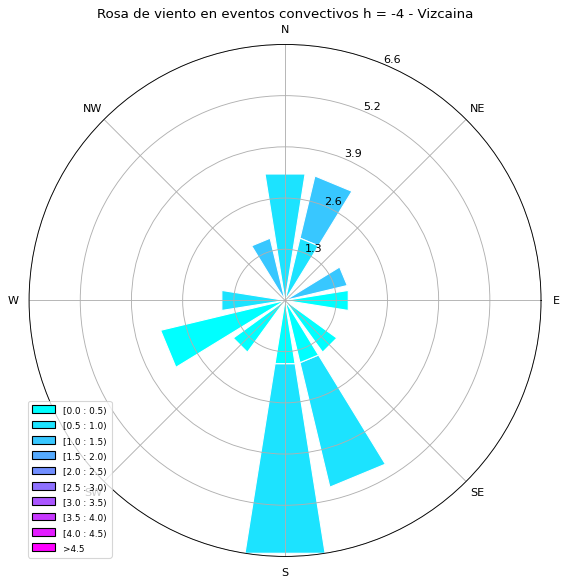

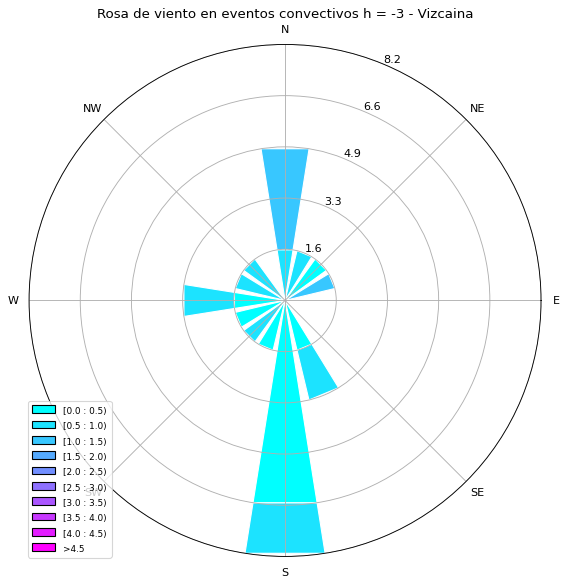

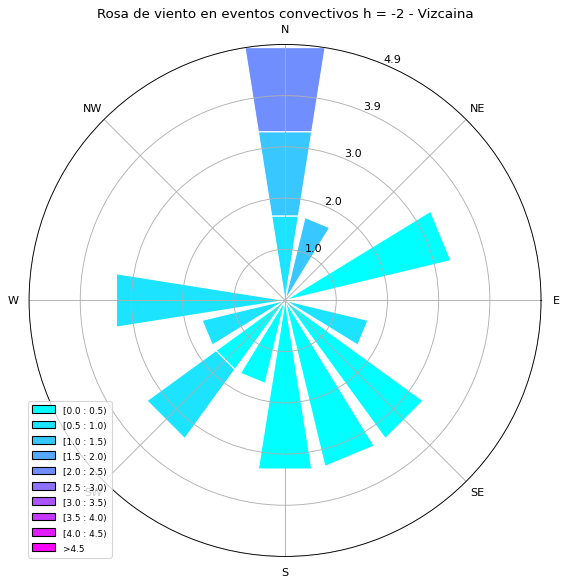

In [52]:
for hora in posHoras:
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'Rosa de viento en eventos convectivos h = {int(hora)} - {NOMBRE_ESTACION.capitalize()}'
  path_to_save = f'windrose_eventos_convectivos_hora_20h_7h_{int(hora)}_{NOMBRE_ESTACION.lower()}.png'

  plot_windrose(dft, title, path_to_save)

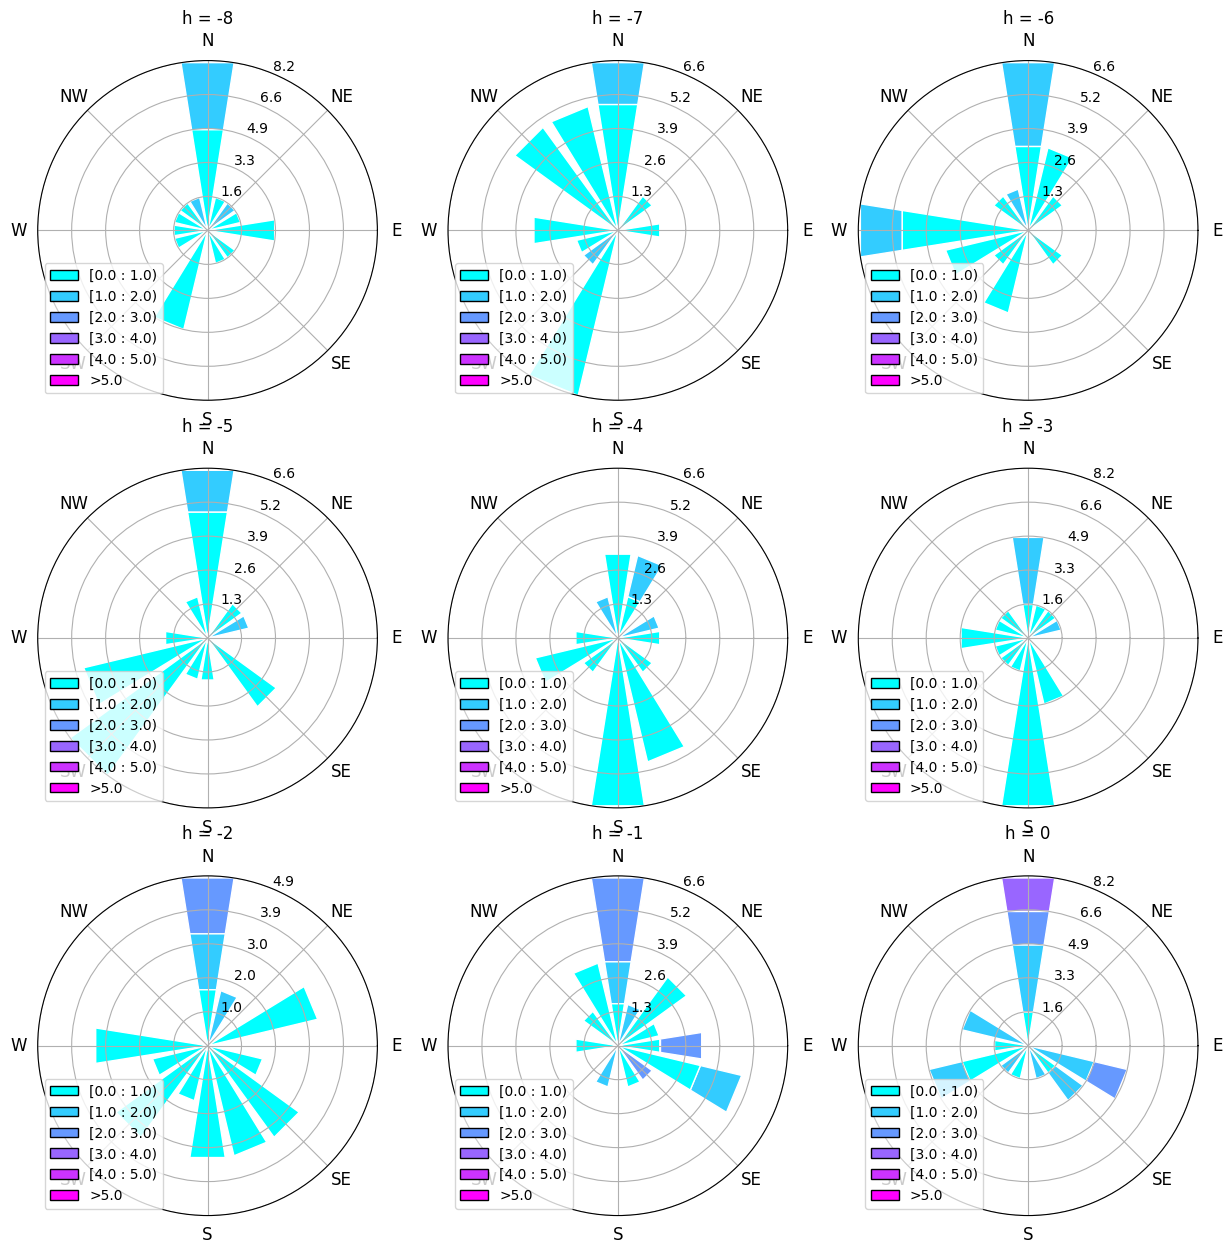

In [53]:
def plot_windrose_2(df, title, ax):
  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, bins=np.arange(0.0, 6), edgecolor='white', cmap=cm.cool)
  ax.legend(loc = 3,fontsize= 10)
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'], fontsize= 12)
  ax.set_title(title)


fig, axs = plt.subplots(3, 3,figsize=(15,15),  subplot_kw=dict(projection="windrose"))
horas = list(posHoras)
horas.sort()

for ax, hora in zip(axs.reshape(9), horas):
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'h = {int(hora)}'
  plot_windrose_2(dft, title, ax)

path_to_save = f'subplot_vientos_20h_7h_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
plt.show()

# Gráficos multivariables en único Plot

In [54]:
dfAnomalia

FECHA_POS TEMP_anomalia           HUM_anomalia           PRESION_anomalia  \
                      mean       std         mean       std             mean   
0         -8      0.159856  1.346051     0.903671  5.289435        -0.709242   
1         -7      0.209668  1.234617     0.720358  4.354349        -0.646450   
2         -6      0.387594  1.416996     0.303439  5.096419        -0.571832   
3         -5      0.441561  1.253533    -0.585757  5.304677        -0.706312   
4         -4      0.220510  0.919109     0.588704  3.965982        -0.538382   
5         -3      0.413138  0.822739     0.375215  3.452764        -0.640219   
6         -2      0.650490  0.812917    -0.229225  3.127396        -0.708797   
7         -1      0.491718  1.002640     0.136461  2.968172        -0.526463   
8          0     -0.033036  1.363542     0.136021  2.444690        -0.440623   
9          1     -0.740054  1.139572     0.388578  2.373367        -0.182518   
10         2     -1.035609  1.265476     1.486024  3.491627        -0.244368   
11         3     -1.119325  1.638270     2.936409  5.840420        -0.304619   
12         4     -1.291212  1.563287     3.916125  7.354576        -0.101515   
13         5     -1.247871  1.536550     4.828906  7.118358         0.018910   
14         6     -1.112179  1.752567     4.937357  8.096408         0.568512   
15         7     -1.196143  1.470295     5.447522  6.294270         0.852130   
16         8     -1.556895  1.689332     6.913407  6.506492         0.226972   

             HUM_ESPECIFICA_anomalia           CERO  
         std                    mean       std       
0   1.171758                0.434533  1.020697    0  
1   1.212804                0.474630  0.962776    0  
2   1.231771                0.500318  0.938117    0  
3   1.291095                0.523418  1.006268    0  
4   1.364153                0.542684  0.868280    0  
5   1.462721                0.781216  0.750599    0  
6   1.604525                0.853052  0.755341    0  
7   1.663567                0.624748  1.048647    0  
8   1.690568                0.142316  1.147254    0  
9   1.805764               -0.537520  1.126536    0  
10  1.917928               -0.538649  1.049525    0  
11  2.173456               -0.372137  0.899888    0  
12  2.320566               -0.453988  0.999356    0  
13  1.989440               -0.372474  1.077745    0  
14  2.168697                0.015874  1.057679    0  
15  2.365410                0.014434  1.020632    0  
16  1.700620                0.122102  1.215382    0

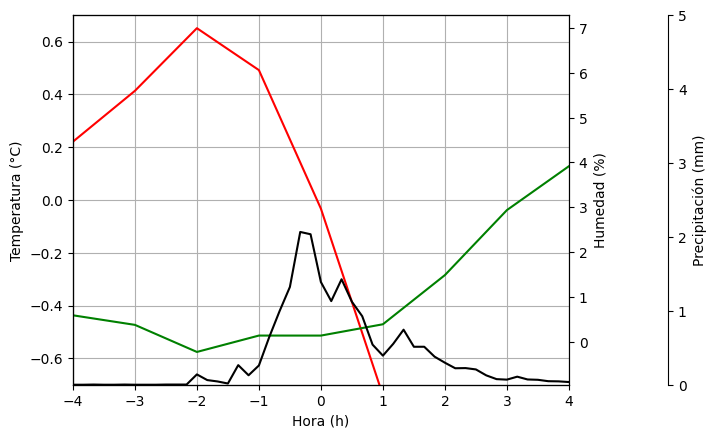

In [55]:
fig, ax = plt.subplots()
ax.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('TEMP_anomalia', 'mean')], c = 'red')
ax.set_ylim(-0.7, 0.7)

ax2=ax.twinx()
ax2.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('HUM_anomalia', 'mean')], c = 'green')

ax3=ax.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
ax3.plot(dfCrossPrecGroup['FECHA_POS']/60.0, dfCrossPrecGroup[('PREC', 'mean')], c = 'black')
ax3.set_ylim(0, 5)

ax.set_xlim(-4, 4)
ax.grid()

ax.set_ylabel("Temperatura (°C)")
ax2.set_ylabel("Humedad (%)")
ax3.set_ylabel("Precipitación (mm)")
ax.set_xlabel("Hora (h)")

path_to_save = f'temp_vs_hum_vs_prec_anomalias_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )